接下来将物理方程约束也写入 loss function：通过训练预测得到的数据，一方面可以通过理论公式计算角加速度，另一方面可以通过差分法得到角加速度，这两个值应该一样，将这个物理条件加入损失函数来训练。

Epoch 1, 训练损失: 2495026.1742, 验证损失: 1532779.9288
Epoch 2, 训练损失: 2467911.0559, 验证损失: 1532779.9323
Epoch 3, 训练损失: 2509226.3102, 验证损失: 1532779.9387
Epoch 4, 训练损失: 2455490.9081, 验证损失: 1532779.9156
Epoch 5, 训练损失: 2445001.9394, 验证损失: 1532779.8998
Epoch 6, 训练损失: 2568288.4069, 验证损失: 1532779.8890
Epoch 7, 训练损失: 2451658.1572, 验证损失: 1532779.8738
Epoch 8, 训练损失: 2455808.1058, 验证损失: 1532779.8609
Epoch 9, 训练损失: 2497181.2236, 验证损失: 1532779.8549
Epoch 10, 训练损失: 2444248.0125, 验证损失: 1532779.8486
Epoch 11, 训练损失: 2507447.7210, 验证损失: 1532779.8441
Epoch 12, 训练损失: 2466955.2106, 验证损失: 1532779.8426
Epoch 13, 训练损失: 2452591.0363, 验证损失: 1532779.8422
Epoch 14, 训练损失: 2495425.1758, 验证损失: 1532779.8417
Epoch 15, 训练损失: 2477479.8148, 验证损失: 1532779.8414
Epoch 16, 训练损失: 2488879.8469, 验证损失: 1532779.8414
Epoch 17, 训练损失: 2493473.8494, 验证损失: 1532779.8411
Epoch 18, 训练损失: 2541007.7068, 验证损失: 1532779.8412
Epoch 19, 训练损失: 2508415.9153, 验证损失: 1532779.8410
Epoch 20, 训练损失: 2466865.2761, 验证损失: 1532779.8412


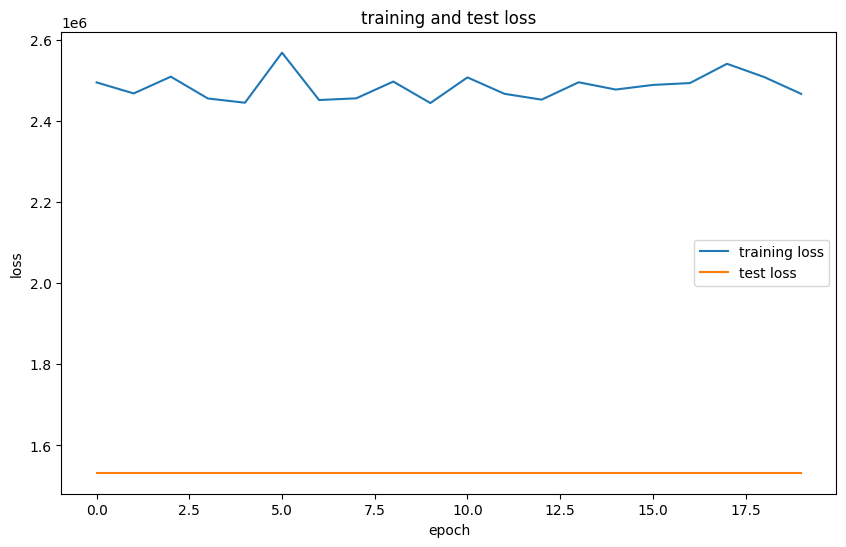

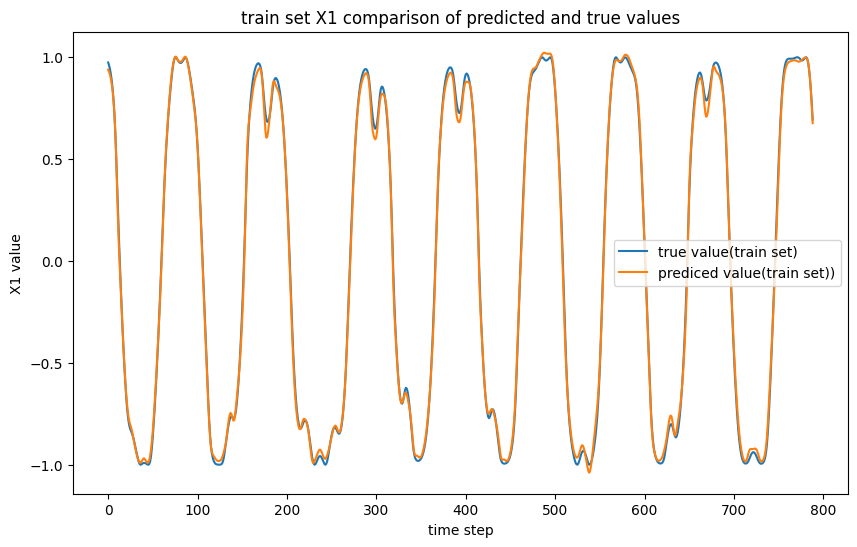

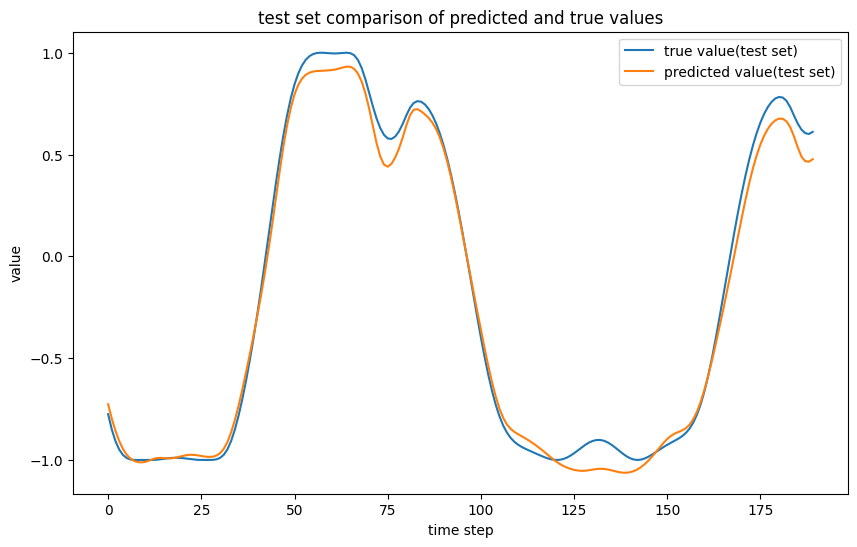

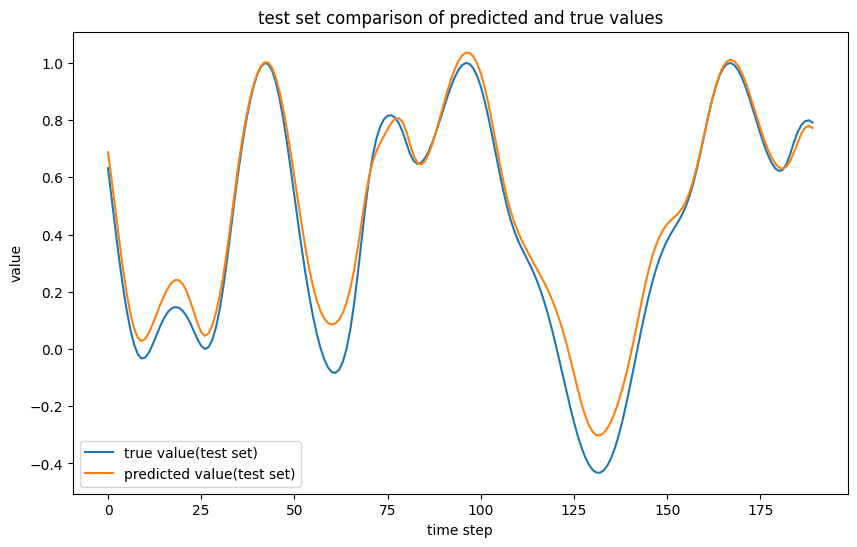

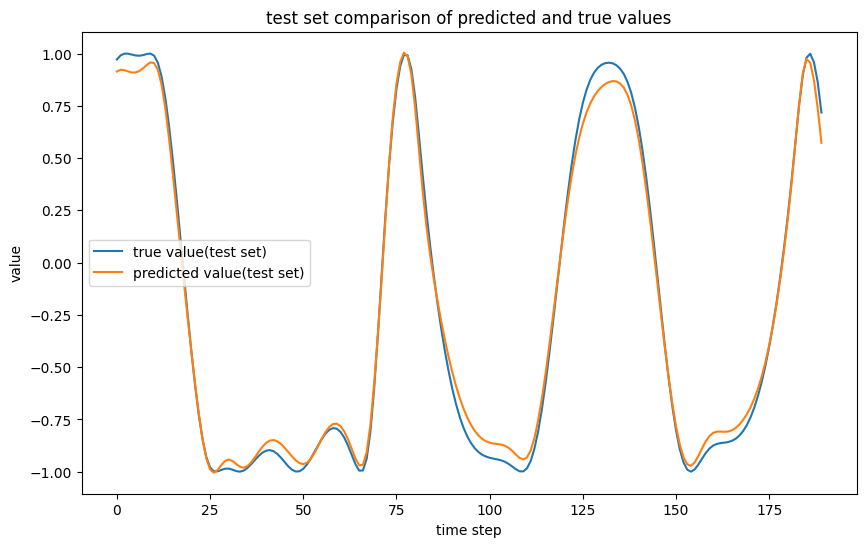

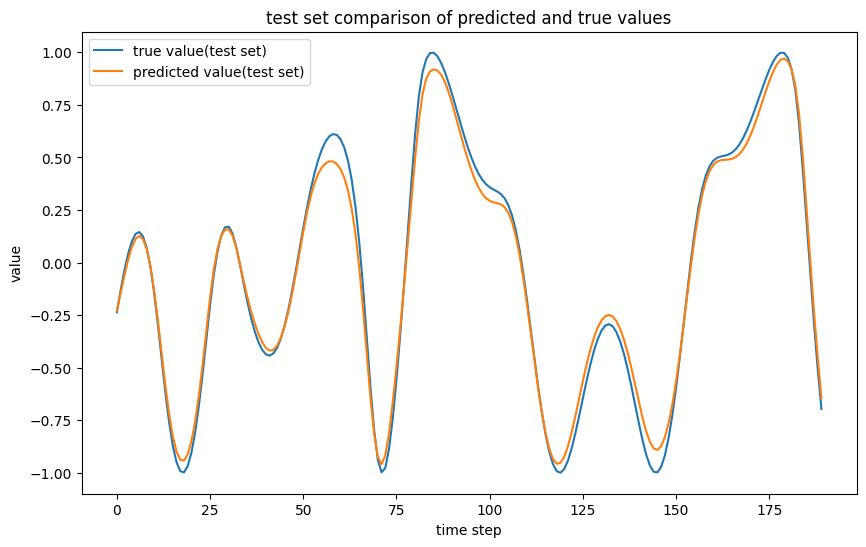

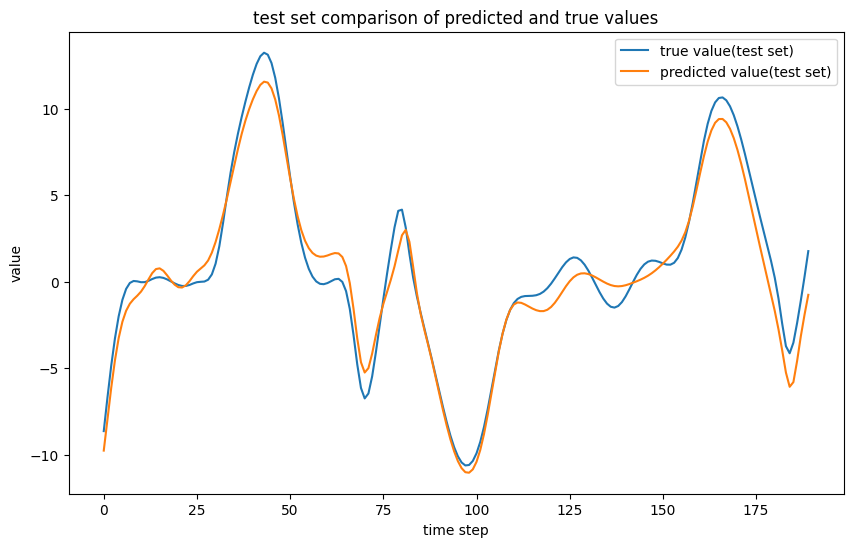

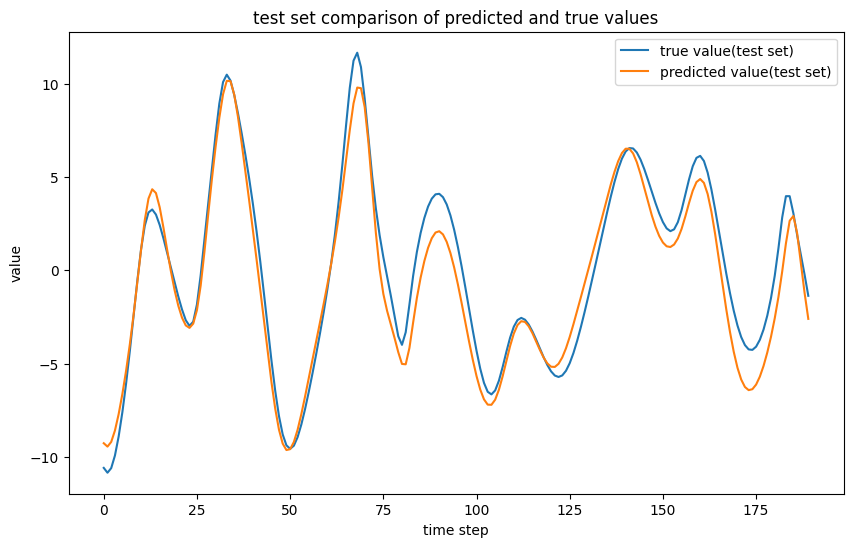

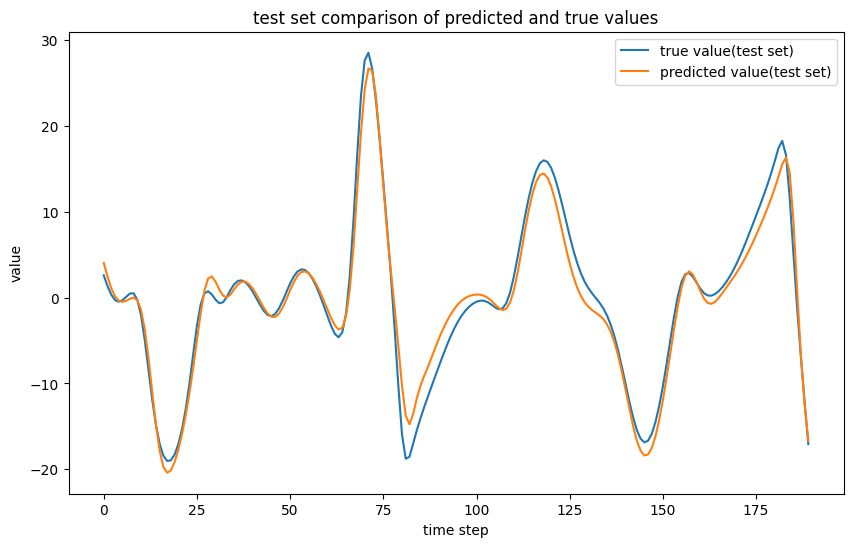

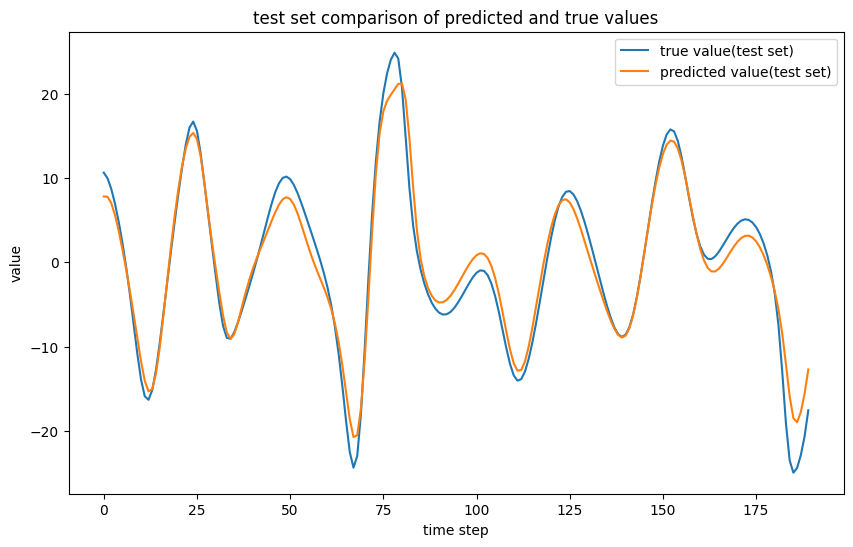

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 50
output_size = y_train.shape[1]

model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 提取坐标和速度信息并反归一化
        def inverse_transform_single_column(data, scaler, column_index):
            temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
            temp[:, column_index] = data.flatten()
            inverse = scaler.inverse_transform(temp)[:, column_index]
            return inverse.reshape(data.shape)

        x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
        y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
        x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
        y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
        vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
        vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
        vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
        vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

        # 计算角度和角速度
        theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
        theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
        omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
        omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        loss = criterion(outputs, yb) + 0.1 * phys_loss  # 调整权重平衡两项损失
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            loss = criterion(outputs, yb) + 0.1 * phys_loss  # 调整权重平衡两项损失
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='prediced value(train set))')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1, 9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

loss很大，且不下降，可能是 data_loss 和 physics_loss 的权重不合适，差较多数量级，先打印前几个batch的loss观察一下两者大小

Epoch 1, Batch 1
data loss: 0.3148932456970215
physics loss: 23319265.86422625
Epoch 1, Batch 2
data loss: 0.28178077936172485
physics loss: 28439030.711141236
Epoch 1, Batch 3
data loss: 0.28077948093414307
physics loss: 20966785.144648775
Epoch 1, Batch 4
data loss: 0.2618766129016876
physics loss: 26217748.19464747
Epoch 1, Batch 5
data loss: 0.23928523063659668
physics loss: 27454473.71555642
Epoch 1, 训练损失: 247467.4281, 验证损失: 153278.1099
Epoch 2, 训练损失: 249078.4121, 验证损失: 153278.0789
Epoch 3, 训练损失: 249158.3417, 验证损失: 153278.0733
Epoch 4, 训练损失: 247264.6520, 验证损失: 153278.0596
Epoch 5, 训练损失: 249716.5756, 验证损失: 153278.0491
Epoch 6, 训练损失: 249233.0140, 验证损失: 153278.0332
Epoch 7, 训练损失: 244080.3227, 验证损失: 153278.0180
Epoch 8, 训练损失: 248453.0671, 验证损失: 153278.0076
Epoch 9, 训练损失: 253359.8840, 验证损失: 153277.9991
Epoch 10, 训练损失: 248281.2667, 验证损失: 153277.9948
Epoch 11, 训练损失: 250012.5868, 验证损失: 153277.9927
Epoch 12, 训练损失: 252985.5702, 验证损失: 153277.9913
Epoch 13, 训练损失: 249438.9090, 验证损失: 153277.991

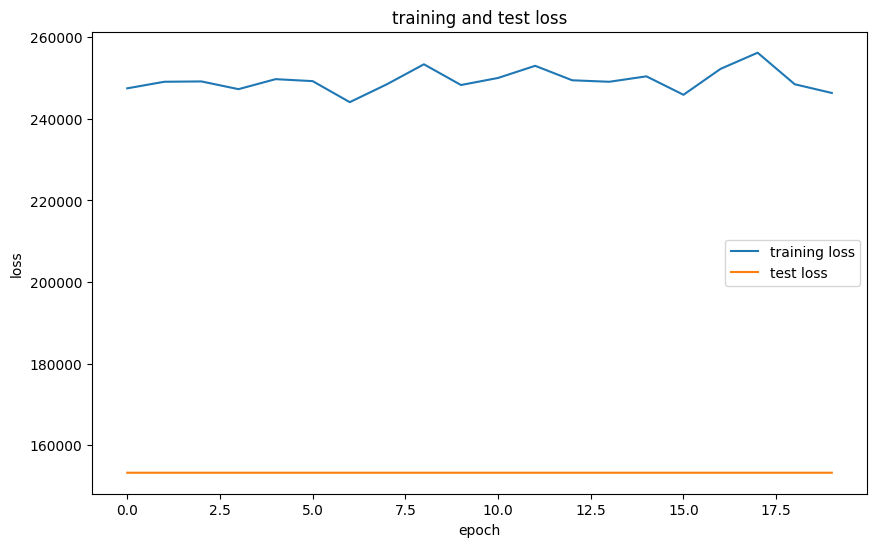

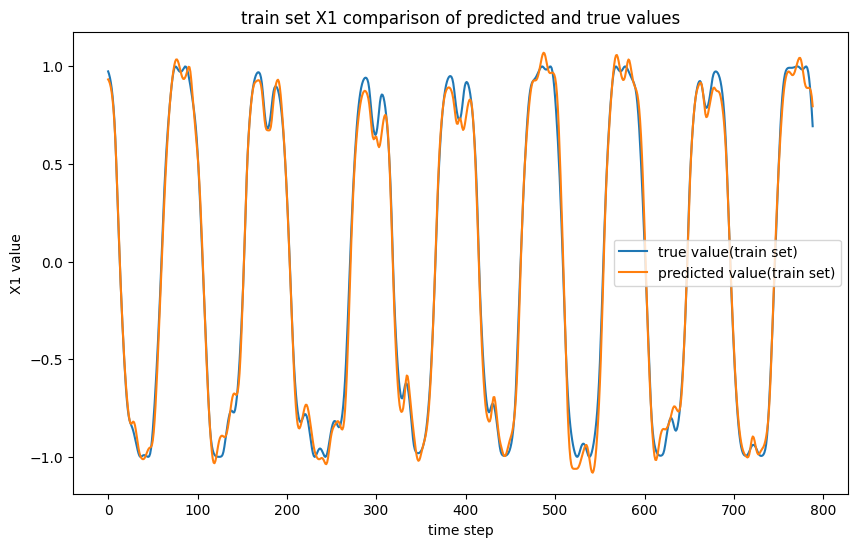

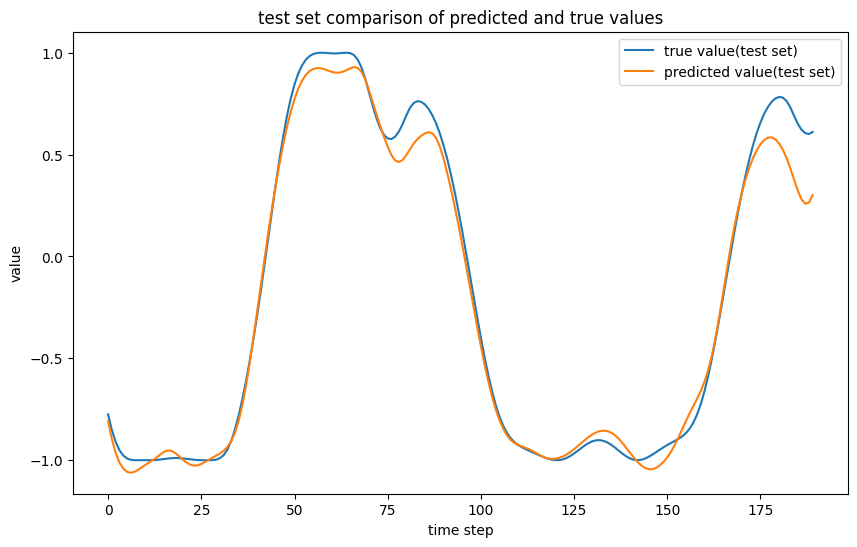

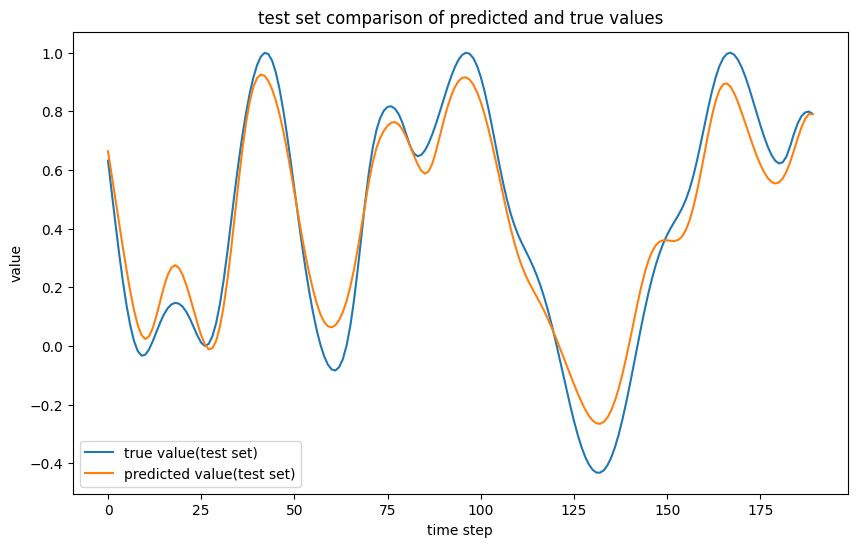

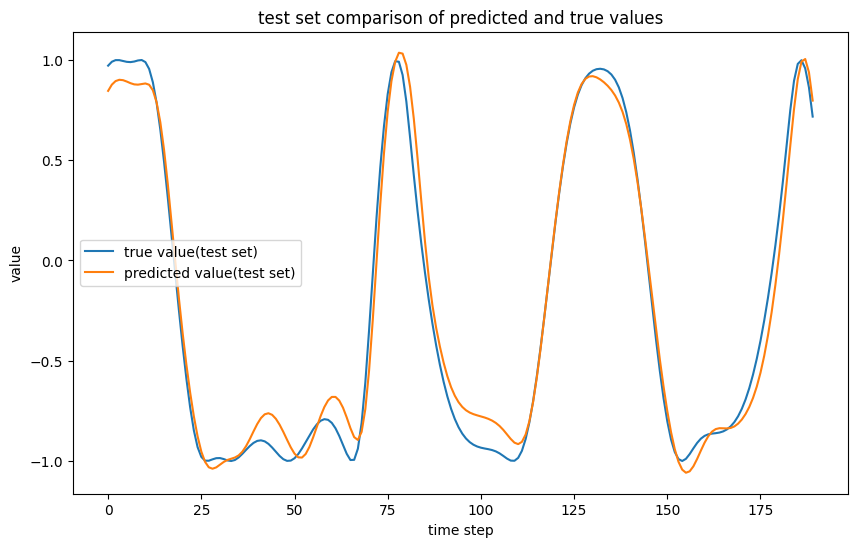

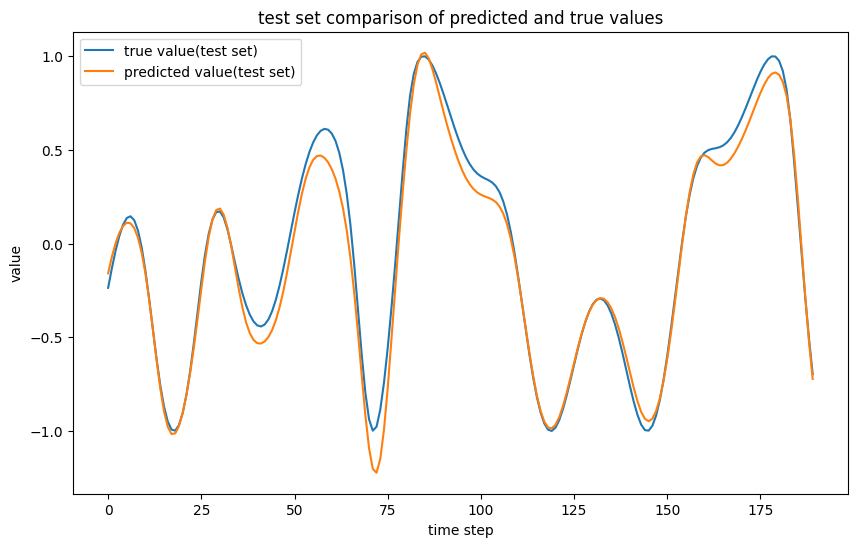

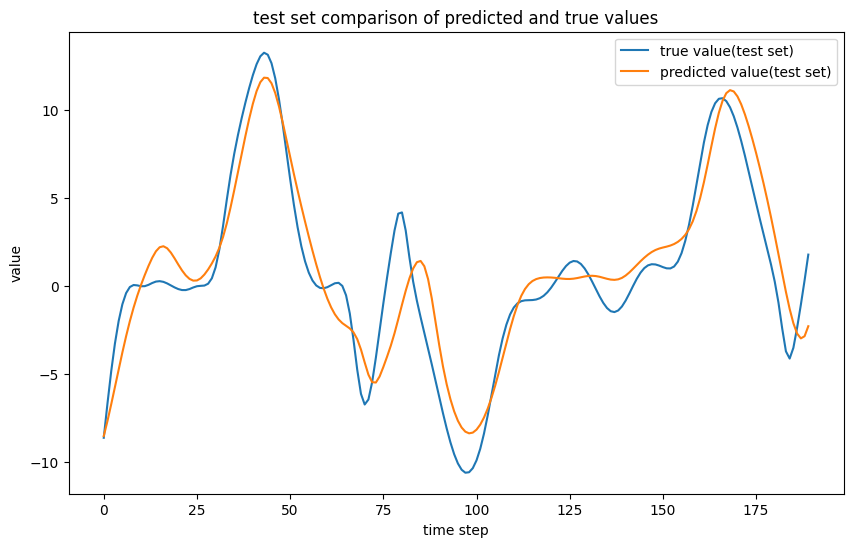

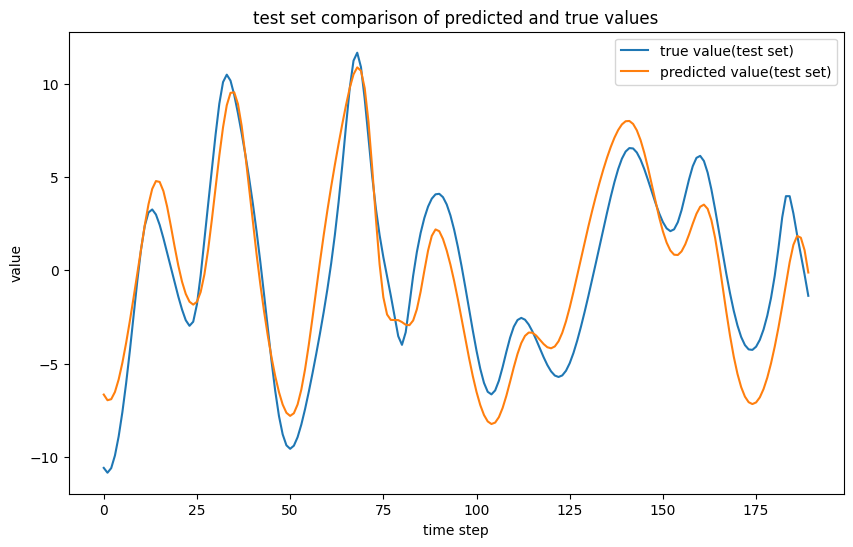

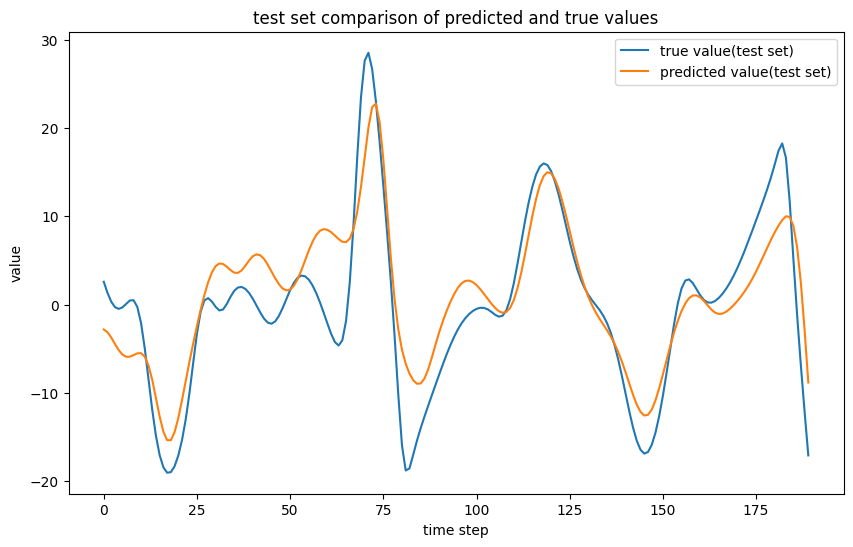

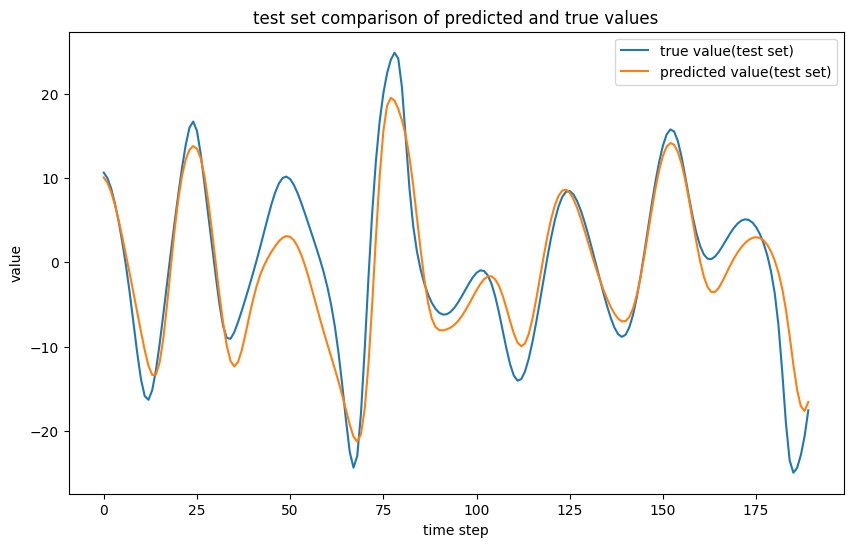

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
output_size = y_train.shape[1]

model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
print_count = 0  # 用于记录打印次数
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 提取坐标和速度信息并反归一化
        def inverse_transform_single_column(data, scaler, column_index):
            temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
            temp[:, column_index] = data.flatten()
            inverse = scaler.inverse_transform(temp)[:, column_index]
            return inverse.reshape(data.shape)

        x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
        y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
        x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
        y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
        vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
        vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
        vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
        vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

        # 计算角度和角速度
        theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
        theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
        omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
        omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        data_loss = criterion(outputs, yb)  # 单独计算data loss
        loss = data_loss + 0.01 * phys_loss  # 调整权重平衡两项损失

        if print_count < 5:  # 打印前5个batch的两种损失值
            print(f"Epoch {epoch + 1}, Batch {print_count + 1}")
            print(f"data loss: {data_loss.item()}")
            print(f"physics loss: {phys_loss.item()}")
            print_count += 1

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            data_loss = criterion(outputs, yb)
            loss = data_loss + 0.01 * phys_loss
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='predicted value(train set)')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1, 9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

果然相差很大，需要匹配到同样数量级

Epoch 1, Batch 1
data loss: 0.35662734508514404
physics loss: 27459527.80293019
Epoch 1, Batch 2
data loss: 0.3542517125606537
physics loss: 29888001.98460392
Epoch 1, Batch 3
data loss: 0.3120676875114441
physics loss: 33357065.421409514
Epoch 1, Batch 4
data loss: 0.2876533269882202
physics loss: 36618004.56447401
Epoch 1, Batch 5
data loss: 0.2740665674209595
physics loss: 30301925.606755383
Epoch 1, 训练损失: 0.3671, 验证损失: 0.4329
Epoch 2, 训练损失: 0.3077, 验证损失: 0.4148
Epoch 3, 训练损失: 0.3034, 验证损失: 0.4131
Epoch 4, 训练损失: 0.3026, 验证损失: 0.4119
Epoch 5, 训练损失: 0.3024, 验证损失: 0.4114
Epoch 6, 训练损失: 0.3021, 验证损失: 0.4113
Epoch 7, 训练损失: 0.3020, 验证损失: 0.4110
Epoch 8, 训练损失: 0.3019, 验证损失: 0.4109
Epoch 9, 训练损失: 0.3018, 验证损失: 0.4110
Epoch 10, 训练损失: 0.3018, 验证损失: 0.4107


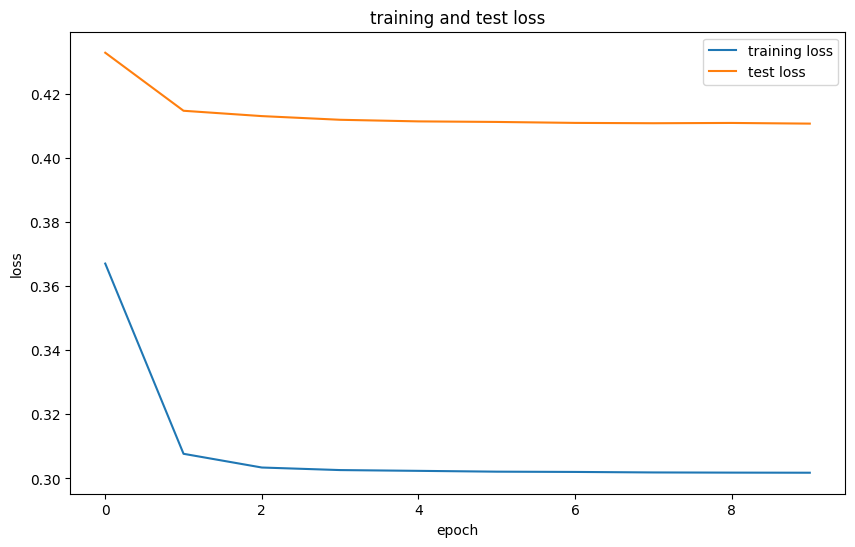

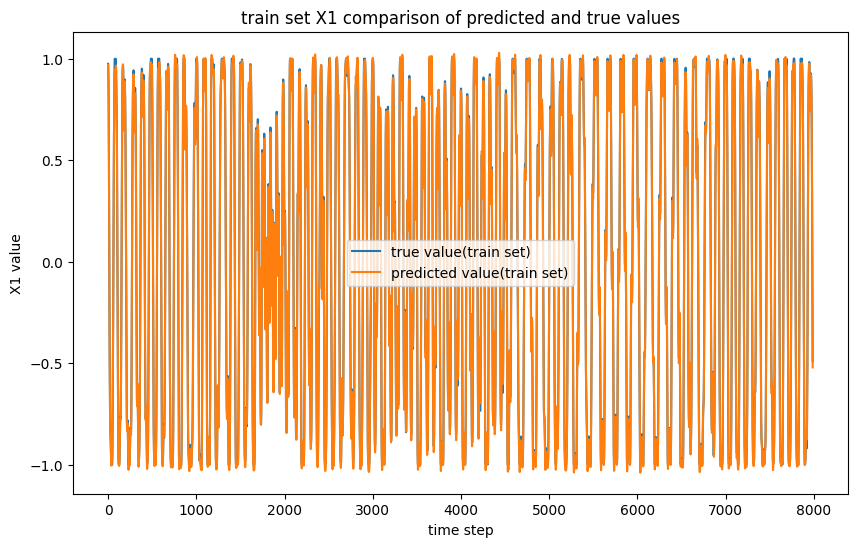

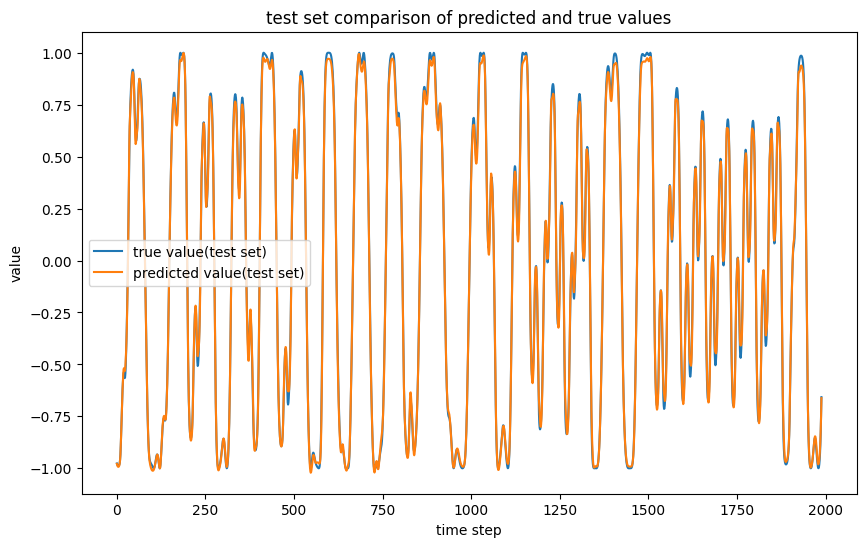

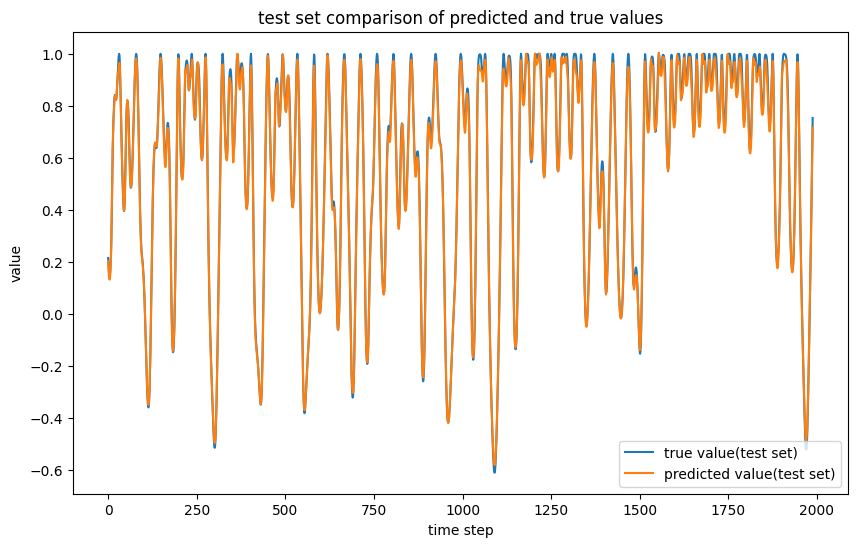

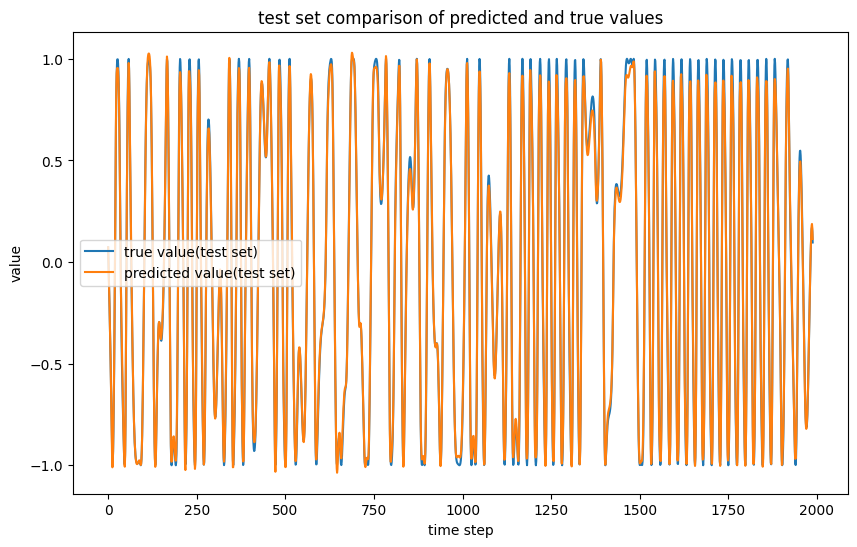

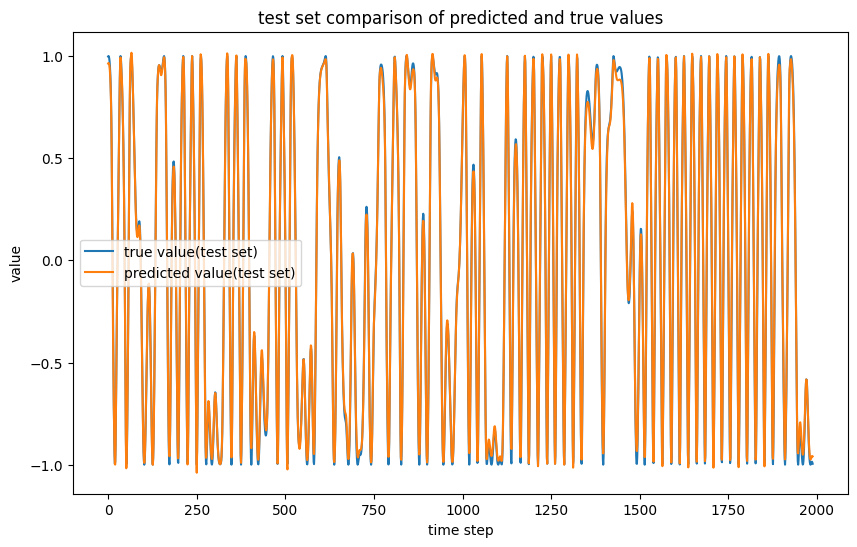

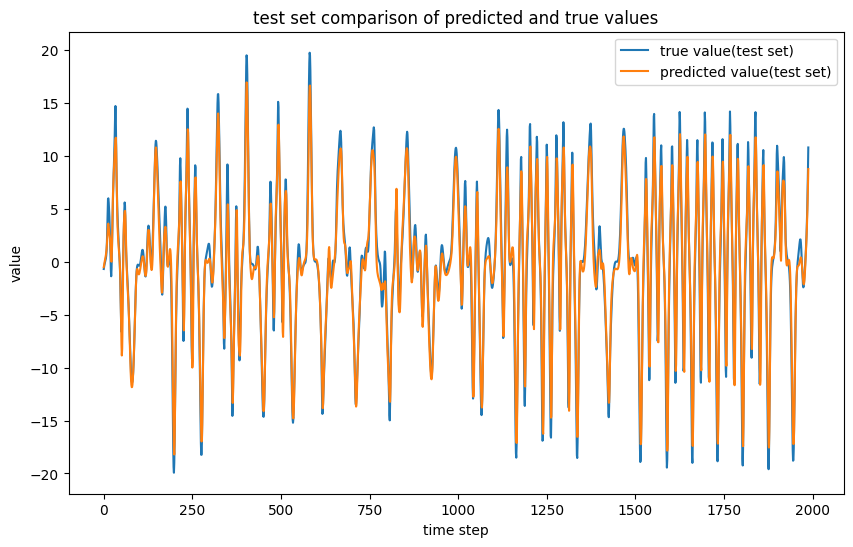

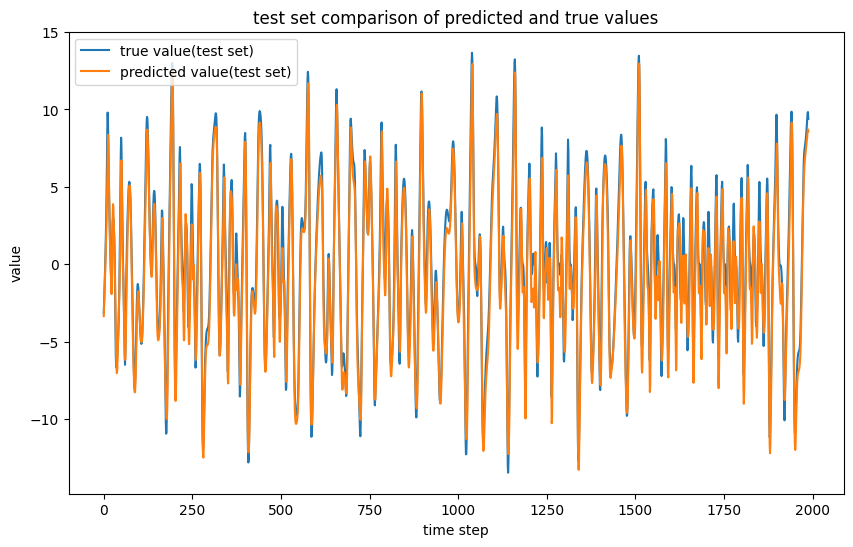

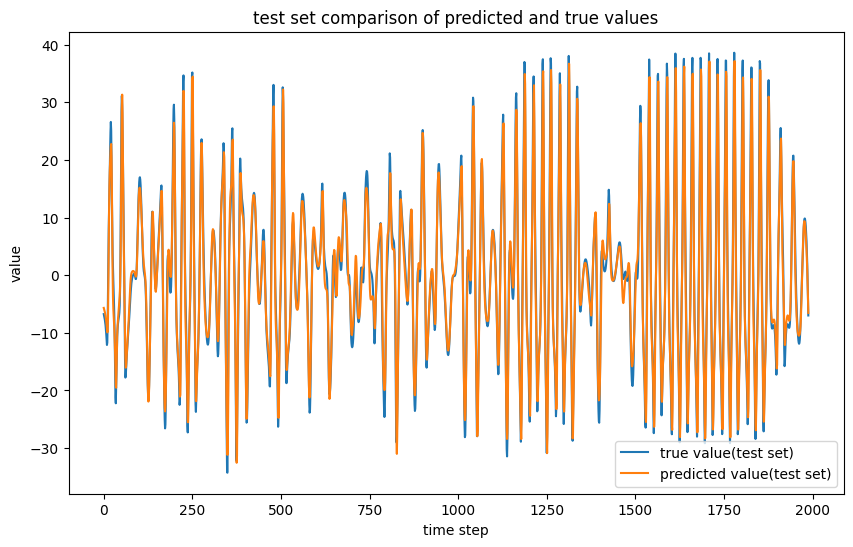

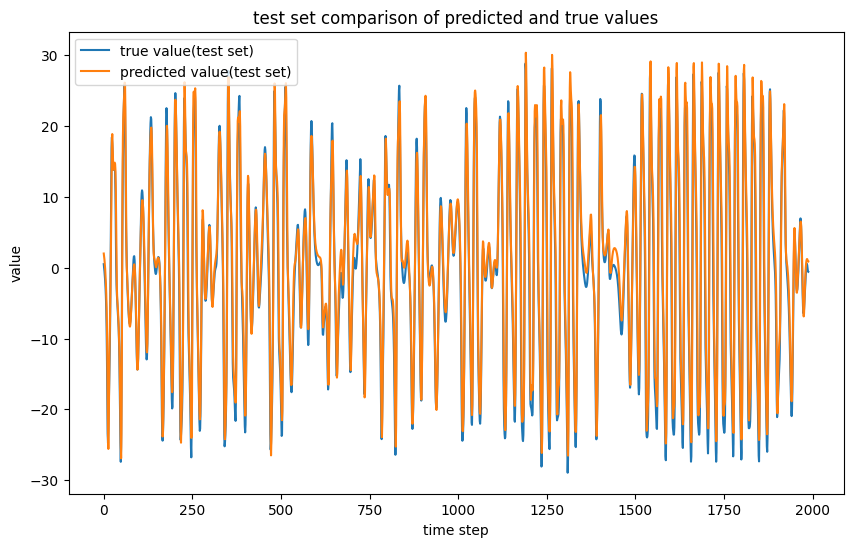

In [28]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
output_size = y_train.shape[1]

model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
print_count = 0  # 用于记录打印次数
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 提取坐标和速度信息并反归一化
        def inverse_transform_single_column(data, scaler, column_index):
            temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
            temp[:, column_index] = data.flatten()
            inverse = scaler.inverse_transform(temp)[:, column_index]
            return inverse.reshape(data.shape)

        x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
        y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
        x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
        y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
        vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
        vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
        vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
        vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

        # 计算角度和角速度
        theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
        theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
        omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
        omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        data_loss = criterion(outputs, yb)  # 单独计算data loss
        loss = data_loss + 10**(-8) * phys_loss  # 调整权重平衡两项损失

        if print_count < 5:  # 打印前5个batch的两种损失值
            print(f"Epoch {epoch + 1}, Batch {print_count + 1}")
            print(f"data loss: {data_loss.item()}")
            print(f"physics loss: {phys_loss.item()}")
            print_count += 1

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            data_loss = criterion(outputs, yb)
            loss = data_loss + 10**(-8) * phys_loss
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='predicted value(train set)')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1, 9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

可以尝试其他网络结构，如 GRU、Transformer 等，尝试增强模型对复杂特征的学习能力

Epoch 1, 训练损失: 0.4031, 验证损失: 0.2510
Epoch 2, 训练损失: 0.3188, 验证损失: 0.2365
Epoch 3, 训练损失: 0.3020, 验证损失: 0.2170
Epoch 4, 训练损失: 0.2901, 验证损失: 0.1987
Epoch 5, 训练损失: 0.2770, 验证损失: 0.1857
Epoch 6, 训练损失: 0.2663, 验证损失: 0.1765
Epoch 7, 训练损失: 0.2623, 验证损失: 0.1651
Epoch 8, 训练损失: 0.2599, 验证损失: 0.1610
Epoch 9, 训练损失: 0.2572, 验证损失: 0.1593
Epoch 10, 训练损失: 0.2517, 验证损失: 0.1578
Epoch 11, 训练损失: 0.2512, 验证损失: 0.1571
Epoch 12, 训练损失: 0.2492, 验证损失: 0.1564
Epoch 13, 训练损失: 0.2580, 验证损失: 0.1557
Epoch 14, 训练损失: 0.2479, 验证损失: 0.1554
Epoch 15, 训练损失: 0.2505, 验证损失: 0.1552
Epoch 16, 训练损失: 0.2487, 验证损失: 0.1553
Epoch 17, 训练损失: 0.2481, 验证损失: 0.1548
Epoch 18, 训练损失: 0.2551, 验证损失: 0.1547
Epoch 19, 训练损失: 0.2507, 验证损失: 0.1548
Epoch 20, 训练损失: 0.2493, 验证损失: 0.1548


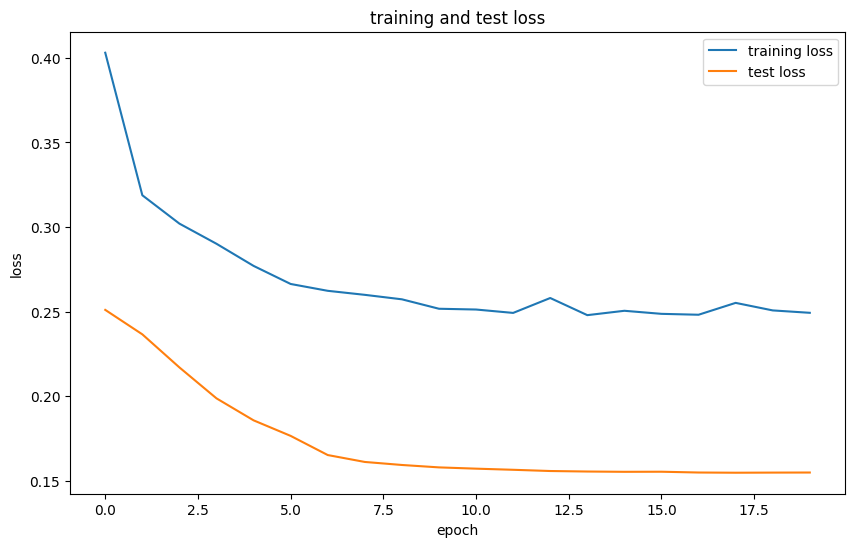

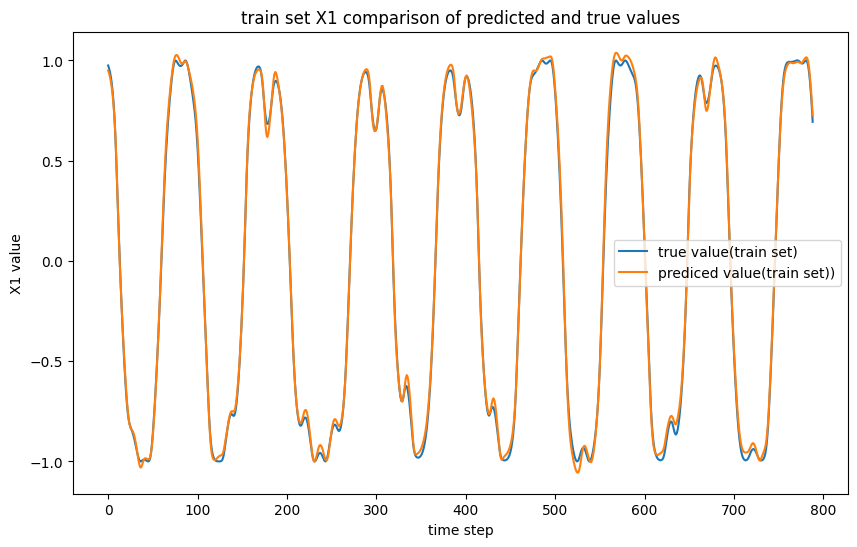

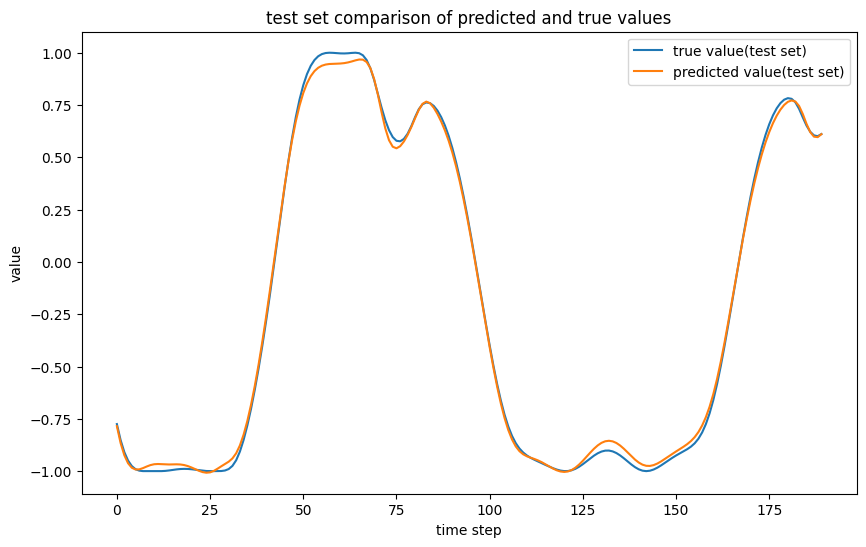

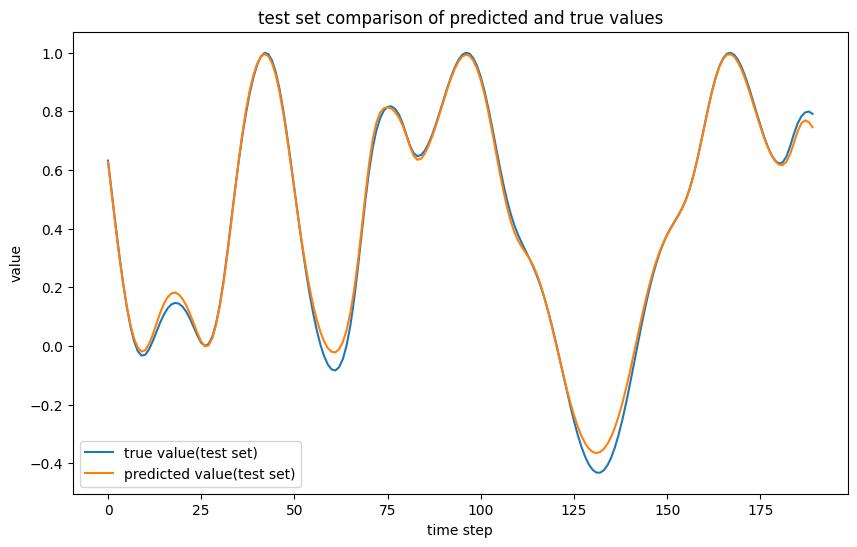

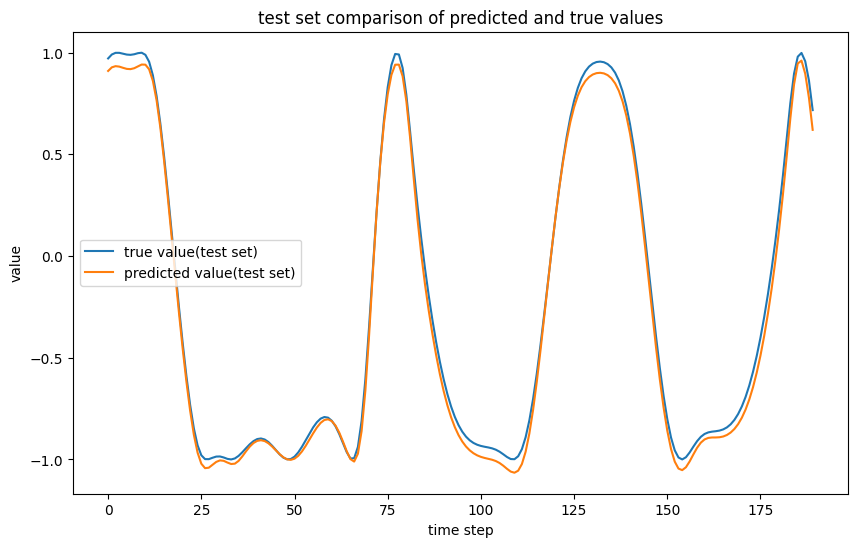

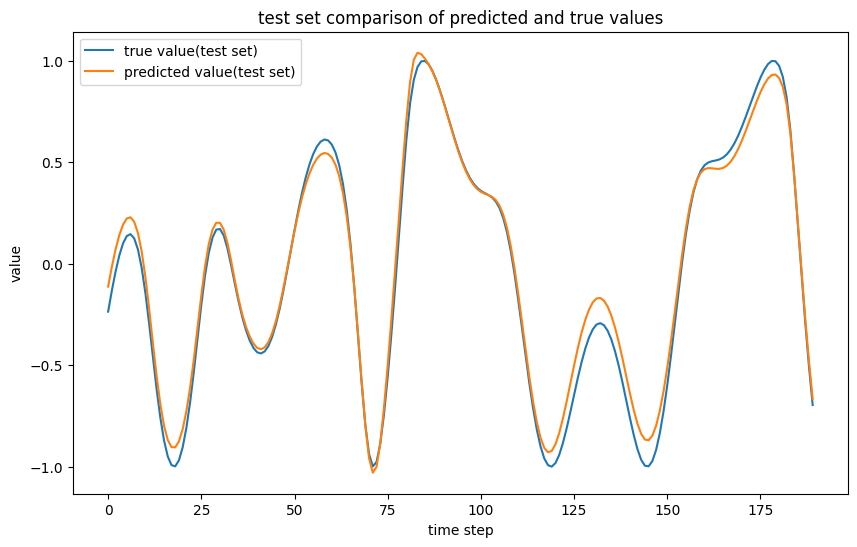

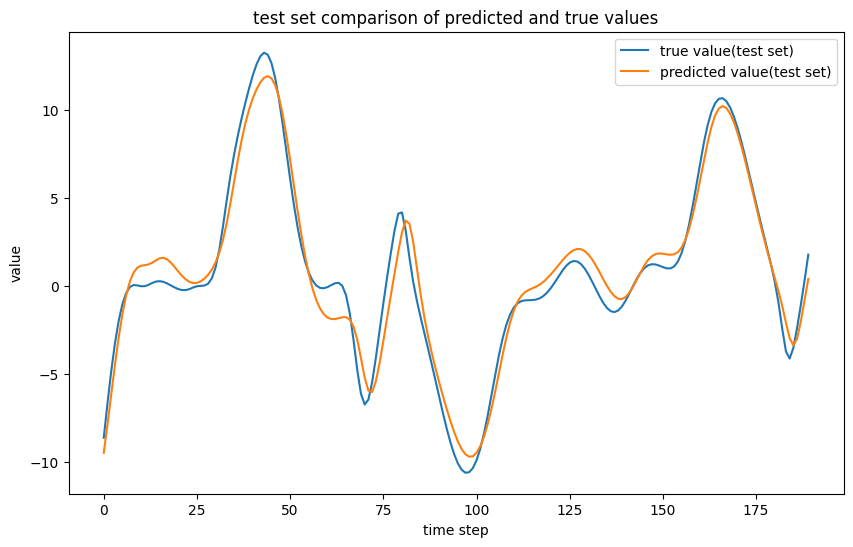

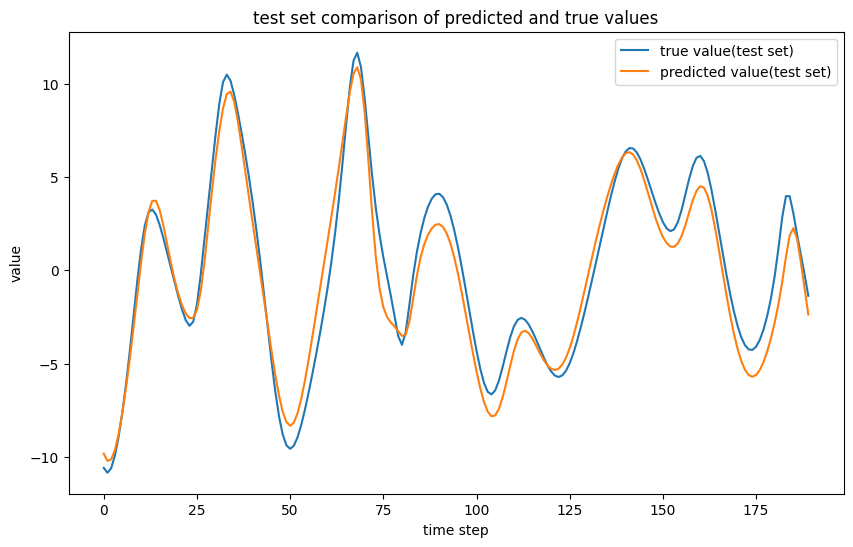

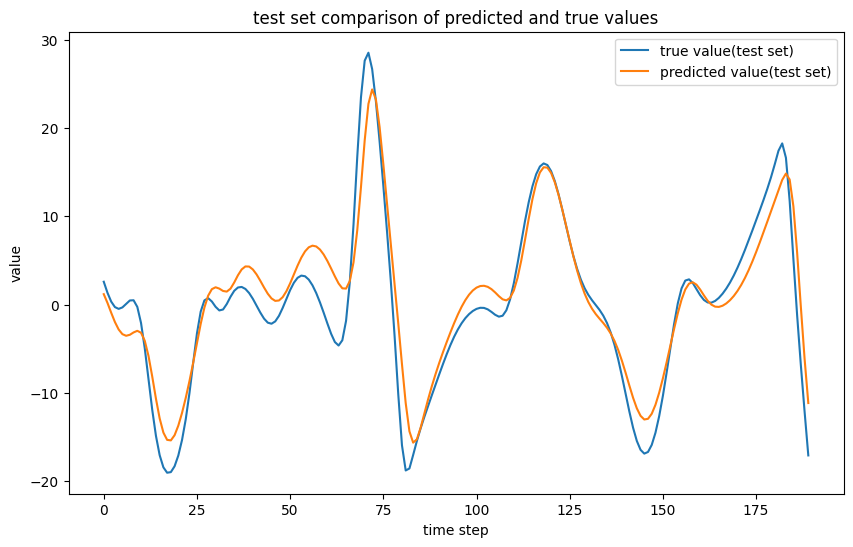

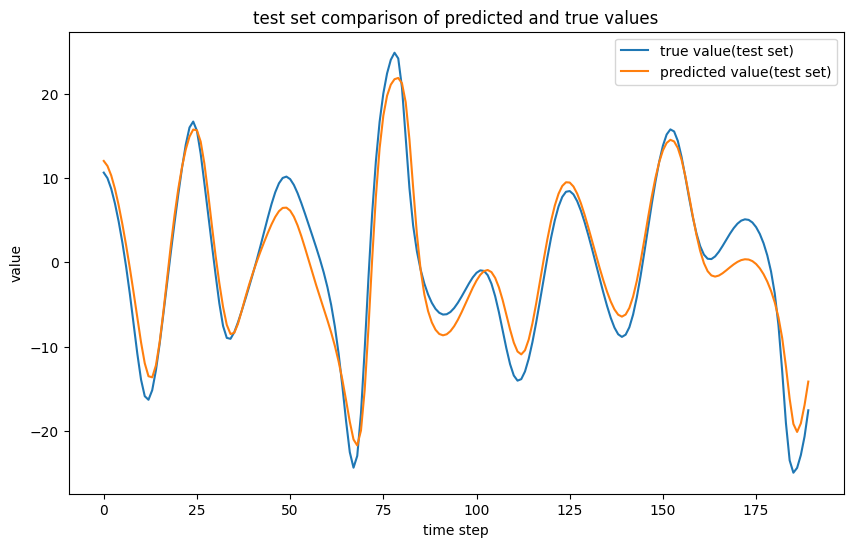

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义GRU模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
output_size = y_train.shape[1]

model = GRUModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 提取坐标和速度信息并反归一化
        def inverse_transform_single_column(data, scaler, column_index):
            temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
            temp[:, column_index] = data.flatten()
            inverse = scaler.inverse_transform(temp)[:, column_index]
            return inverse.reshape(data.shape)

        x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
        y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
        x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
        y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
        vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
        vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
        vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
        vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

        # 计算角度和角速度
        theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
        theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
        omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
        omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        loss = criterion(outputs, yb) + 10**(-8) * phys_loss  # 调整权重平衡两项损失
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            loss = criterion(outputs, yb) + 10**(-8) * phys_loss  # 调整权重平衡两项损失
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='prediced value(train set))')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1, 9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

以上使用GRU，效果相差不大

d:\Python 3.11.5\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, 训练损失: 0.5886, 验证损失: 0.2516
Epoch 2, 训练损失: 0.3489, 验证损失: 0.2692
Epoch 3, 训练损失: 0.3267, 验证损失: 0.2316
Epoch 4, 训练损失: 0.3087, 验证损失: 0.1996
Epoch 5, 训练损失: 0.2856, 验证损失: 0.1754
Epoch 6, 训练损失: 0.2752, 验证损失: 0.1641
Epoch 7, 训练损失: 0.2687, 验证损失: 0.1604
Epoch 8, 训练损失: 0.2635, 验证损失: 0.1590
Epoch 9, 训练损失: 0.2607, 验证损失: 0.1582
Epoch 10, 训练损失: 0.2560, 验证损失: 0.1580
Epoch 11, 训练损失: 0.2602, 验证损失: 0.1568
Epoch 12, 训练损失: 0.2550, 验证损失: 0.1565
Epoch 13, 训练损失: 0.2530, 验证损失: 0.1571
Epoch 14, 训练损失: 0.2575, 验证损失: 0.1572
Epoch 15, 训练损失: 0.2548, 验证损失: 0.1551
Epoch 16, 训练损失: 0.2513, 验证损失: 0.1557
Epoch 17, 训练损失: 0.2557, 验证损失: 0.1559
Epoch 18, 训练损失: 0.2516, 验证损失: 0.1555
Epoch 19, 训练损失: 0.2523, 验证损失: 0.1562
Epoch 20, 训练损失: 0.2515, 验证损失: 0.1549


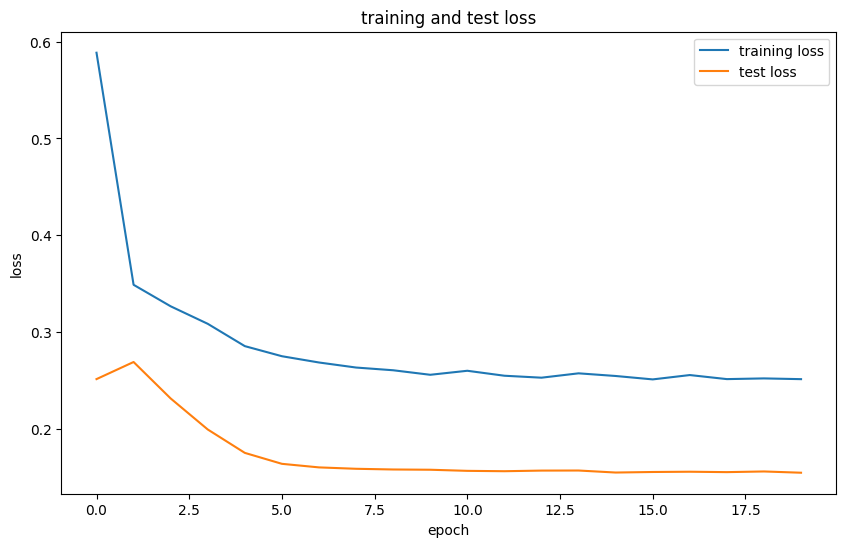

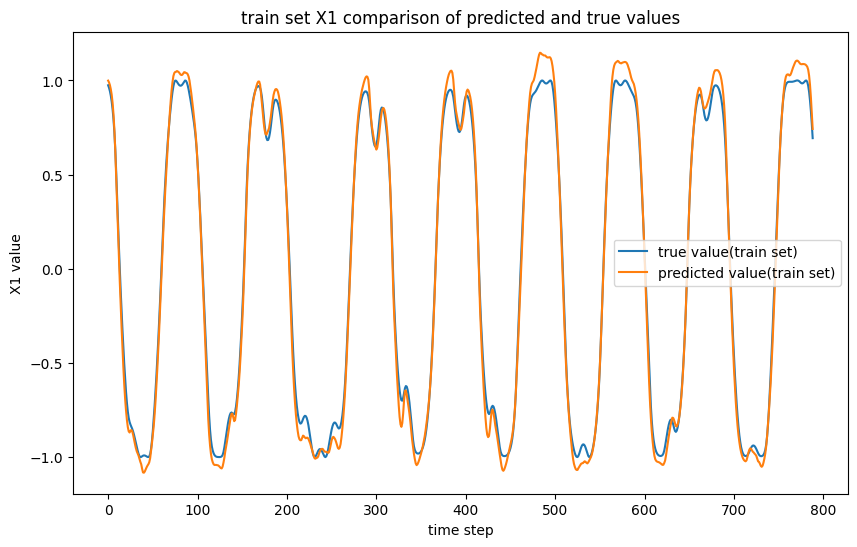

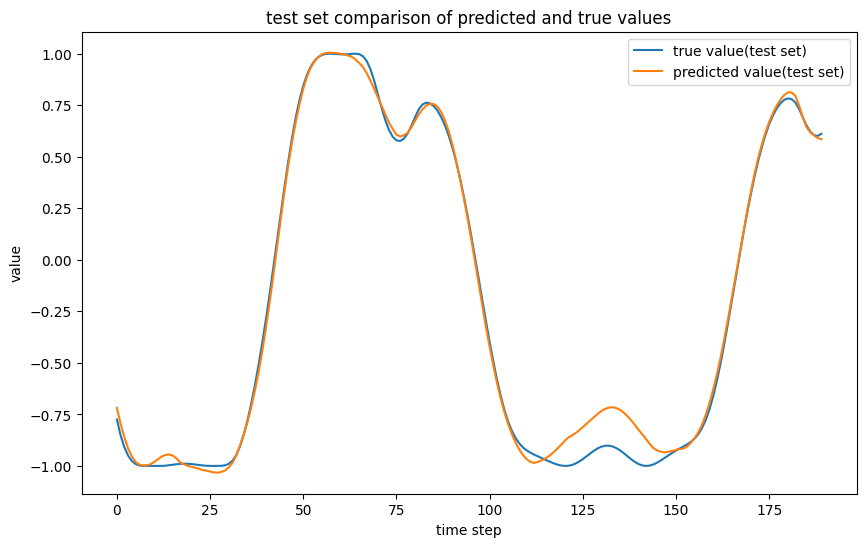

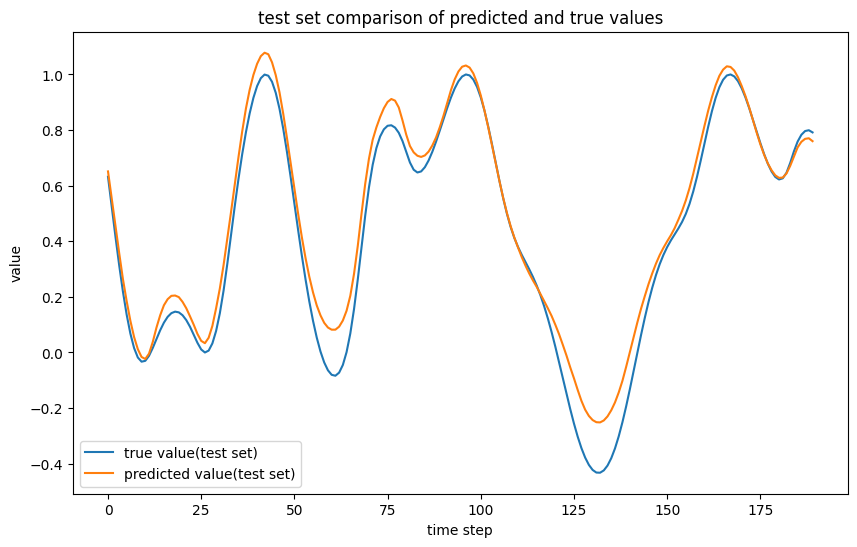

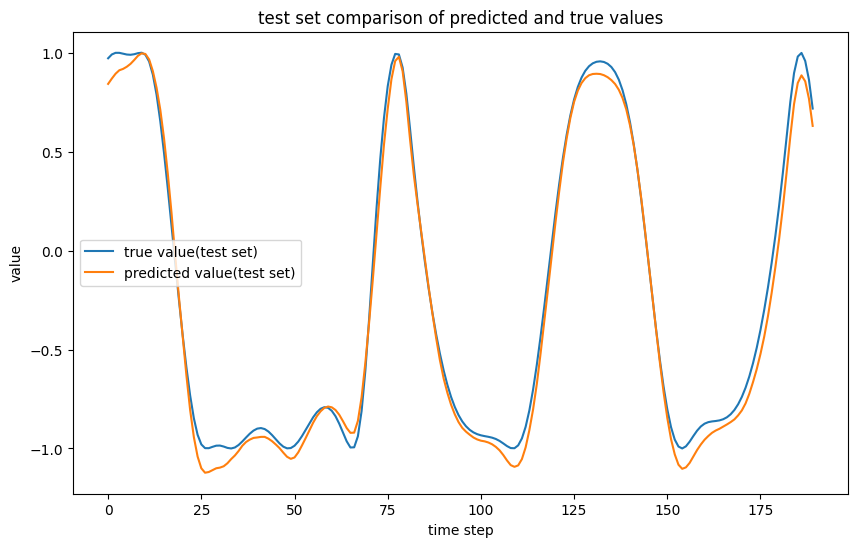

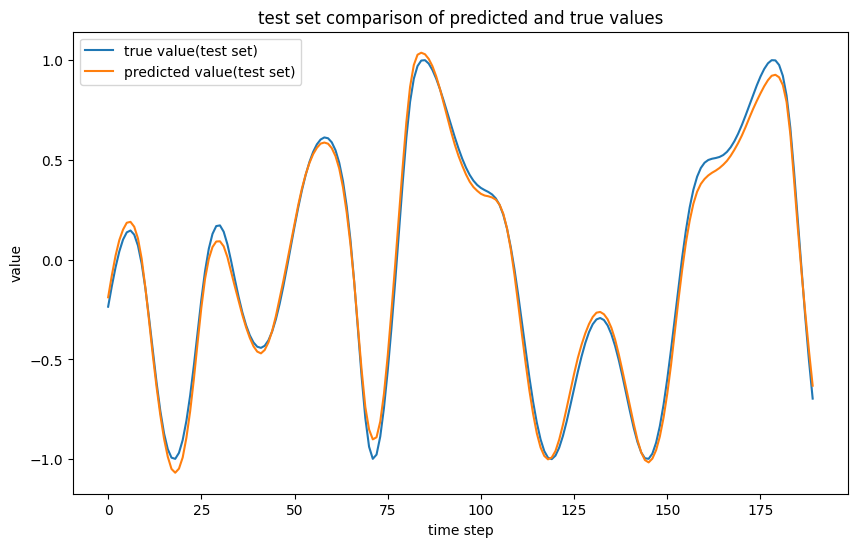

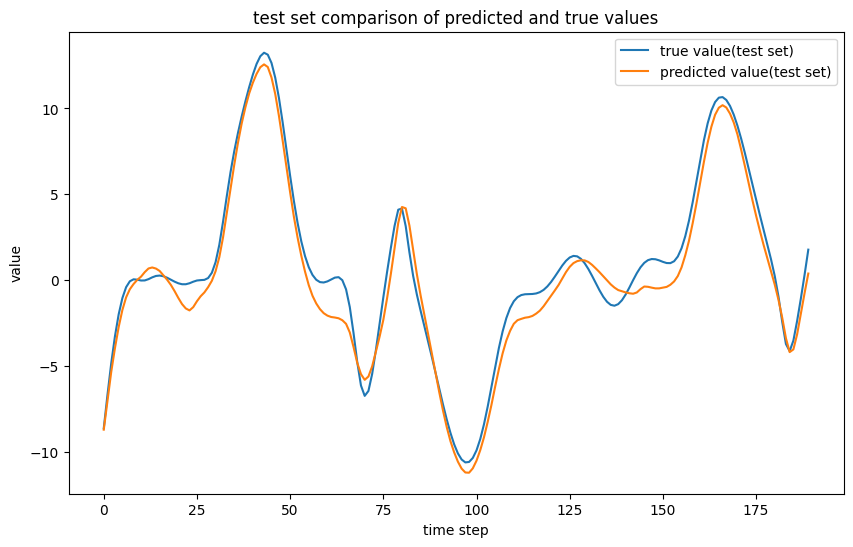

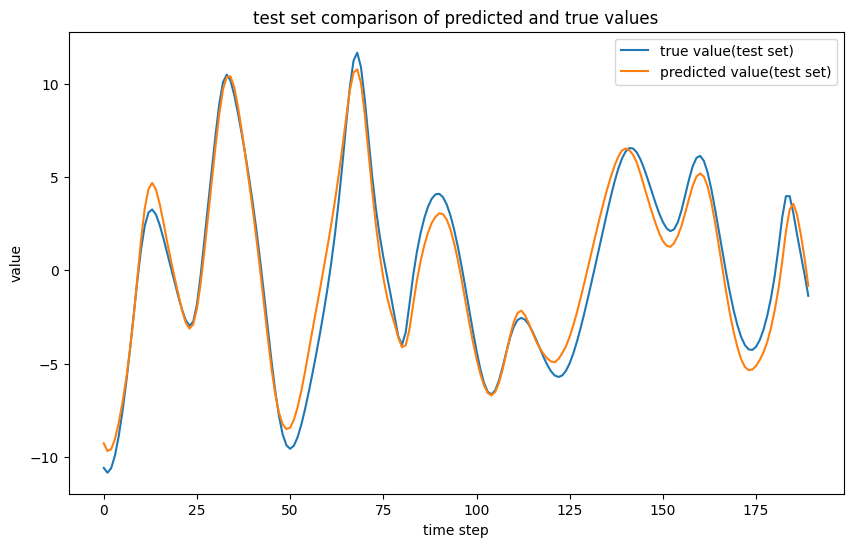

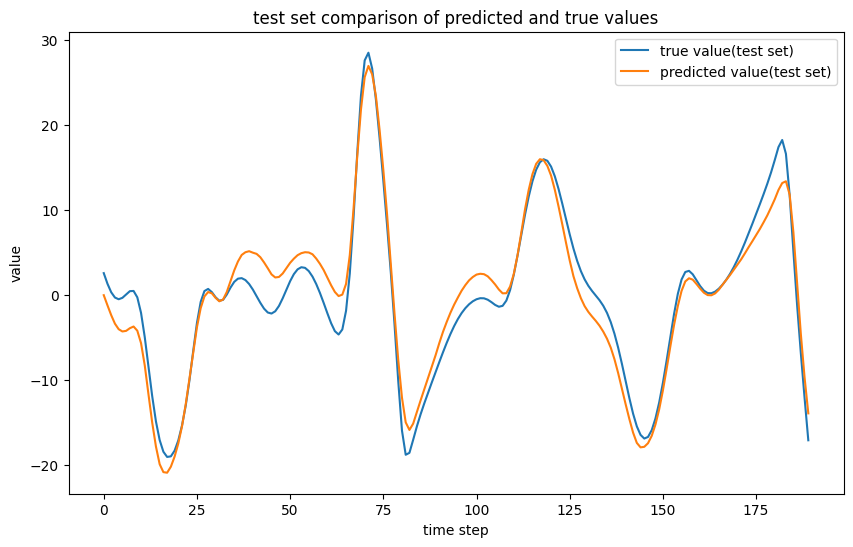

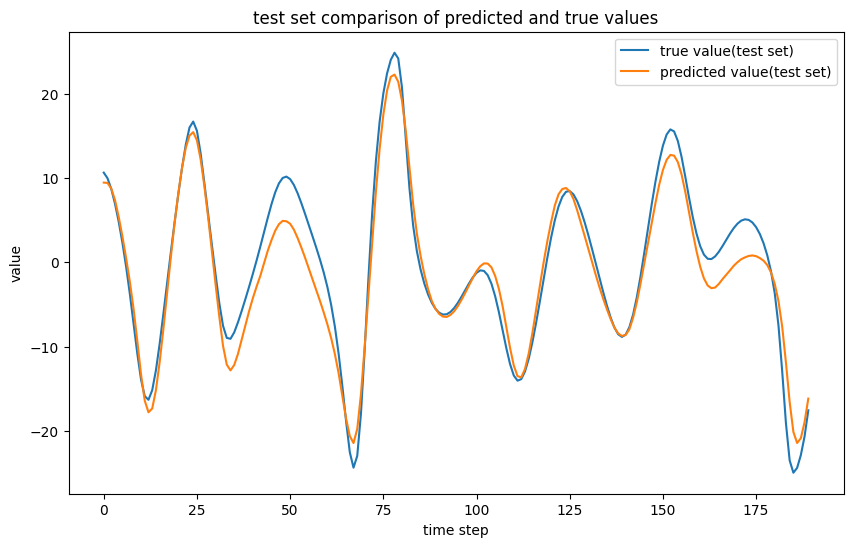

In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, output_size):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # [seq_length, batch_size, d_model]
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # [batch_size, seq_length, d_model]
        x = self.fc(x[:, -1, :])
        return x

input_size = X_train.shape[2]
d_model = 128  # 特征维度
nhead = 8  # 多头注意力头数
num_layers = 3  # Transformer 层数
output_size = y_train.shape[1]

model = TransformerModel(input_size, d_model, nhead, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 提取坐标和速度信息并反归一化
        def inverse_transform_single_column(data, scaler, column_index):
            temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
            temp[:, column_index] = data.flatten()
            inverse = scaler.inverse_transform(temp)[:, column_index]
            return inverse.reshape(data.shape)

        x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
        y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
        x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
        y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
        vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
        vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
        vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
        vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

        # 计算角度和角速度
        theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
        theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
        omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
        omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        data_loss = criterion(outputs, yb)
        loss = data_loss + 10**(-8) * phys_loss  # 平衡两项损失

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            data_loss = criterion(outputs, yb)
            loss = data_loss + 10**(-8)* phys_loss
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='predicted value(train set)')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1, 9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

以上使用Transformer，效果与GRU和LSTM差不多，没有明显优势。
再尝试其他优化：
网络结构上，在 LSTM 中添加了 Dropout 层，并且增加了 LSTM 层的数量；
学习率上，尝试用 ReduceLROnPlateau 调度器，当验证集损失在连续 3 个 epoch 内没有下降时，将学习率降低为原来的 0.1 倍；
正则化，在优化器中添加了 weight_decay 参数，实现 L2 正则化；
epochs，增加为40;
早停，当验证集损失在连续 5 个 epoch 内没有下降时，提前停止训练。

Epoch 1, 训练损失: 0.4717, 验证损失: 0.2570
Epoch 2, 训练损失: 0.3353, 验证损失: 0.2654
Epoch 3, 训练损失: 0.3256, 验证损失: 0.2430
Epoch 4, 训练损失: 0.3232, 验证损失: 0.2483
Epoch 5, 训练损失: 0.3126, 验证损失: 0.2378
Epoch 6, 训练损失: 0.3121, 验证损失: 0.2266
Epoch 7, 训练损失: 0.2962, 验证损失: 0.2145
Epoch 8, 训练损失: 0.2892, 验证损失: 0.2073
Epoch 9, 训练损失: 0.2812, 验证损失: 0.1981
Epoch 10, 训练损失: 0.2752, 验证损失: 0.1819
Epoch 11, 训练损失: 0.2718, 验证损失: 0.1741
Epoch 12, 训练损失: 0.2662, 验证损失: 0.1724
Epoch 13, 训练损失: 0.2620, 验证损失: 0.1695
Epoch 14, 训练损失: 0.2585, 验证损失: 0.1676
Epoch 15, 训练损失: 0.2573, 验证损失: 0.1644
Epoch 16, 训练损失: 0.2570, 验证损失: 0.1640
Epoch 17, 训练损失: 0.2589, 验证损失: 0.1627
Epoch 18, 训练损失: 0.2542, 验证损失: 0.1625
Epoch 19, 训练损失: 0.2558, 验证损失: 0.1625
Epoch 20, 训练损失: 0.2561, 验证损失: 0.1617
Epoch 21, 训练损失: 0.2484, 验证损失: 0.1613
Epoch 22, 训练损失: 0.2569, 验证损失: 0.1602
Epoch 23, 训练损失: 0.2551, 验证损失: 0.1605
Epoch 24, 训练损失: 0.2537, 验证损失: 0.1602
Epoch 25, 训练损失: 0.2523, 验证损失: 0.1610
Epoch 26, 训练损失: 0.2572, 验证损失: 0.1601
Epoch 27, 训练损失: 0.2494, 验证损失: 0.1596
Epoch 28, 

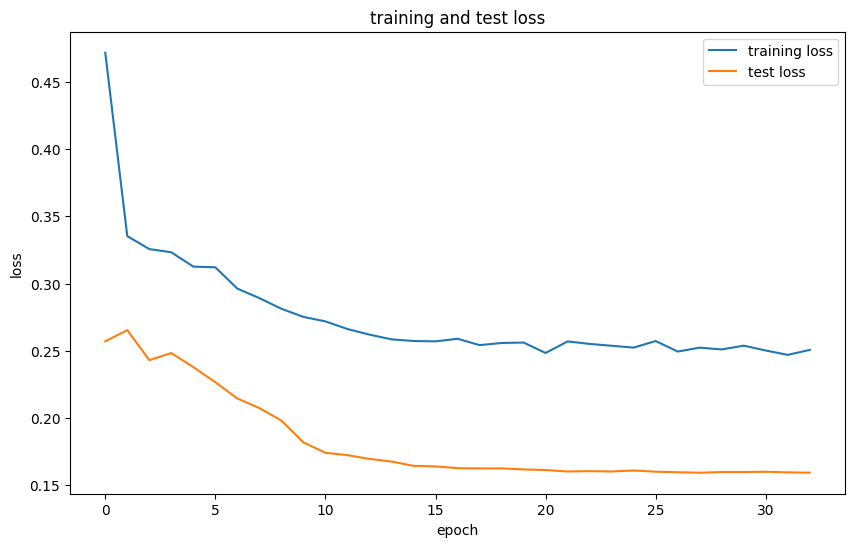

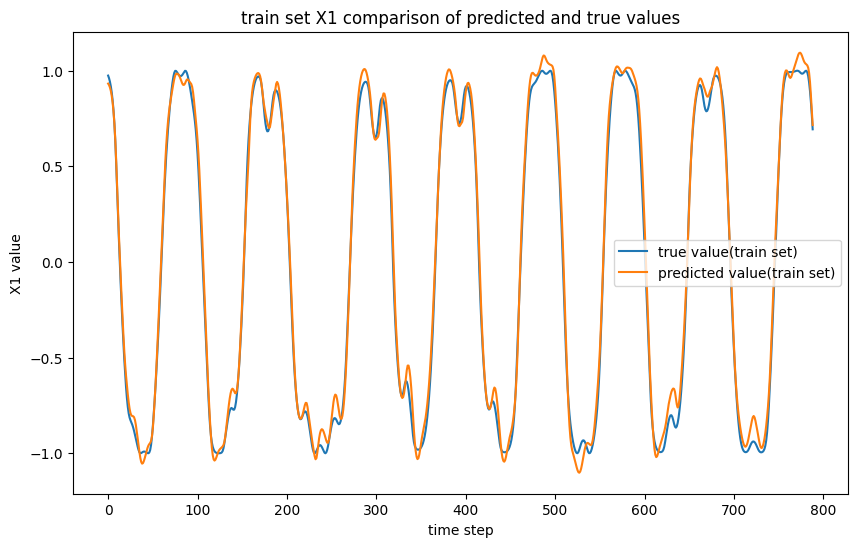

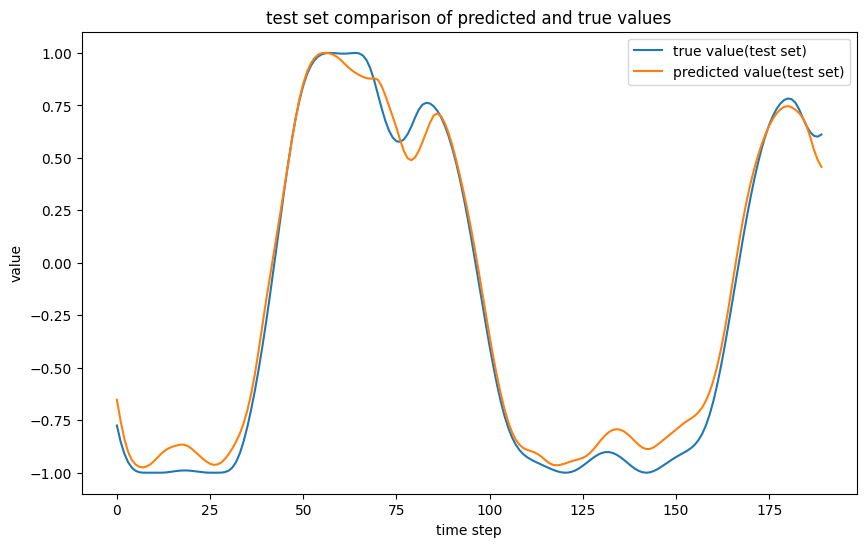

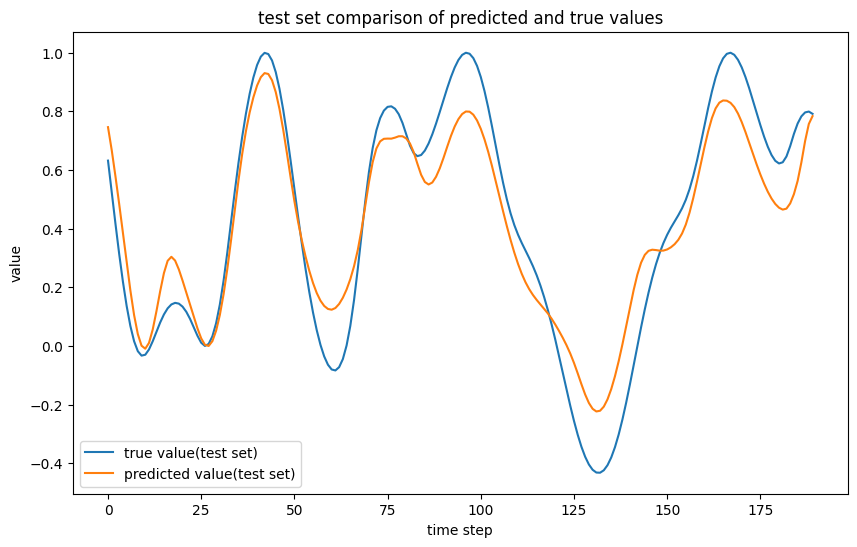

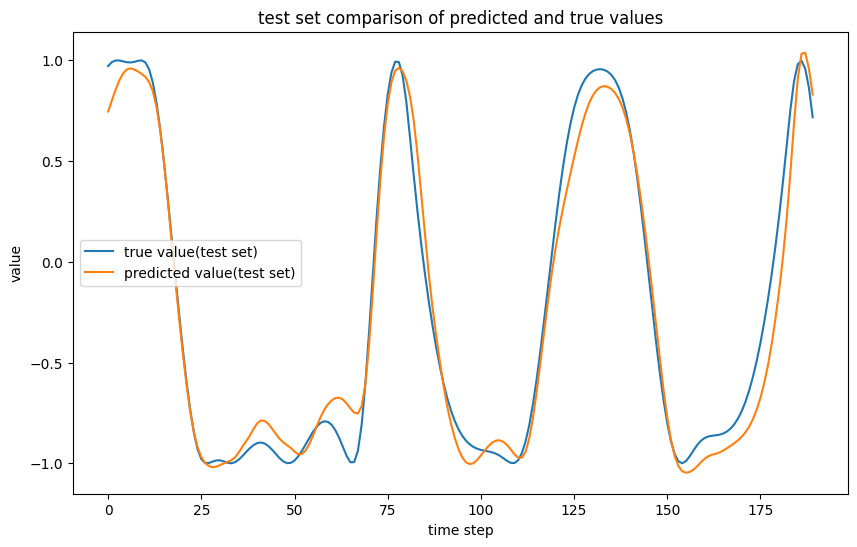

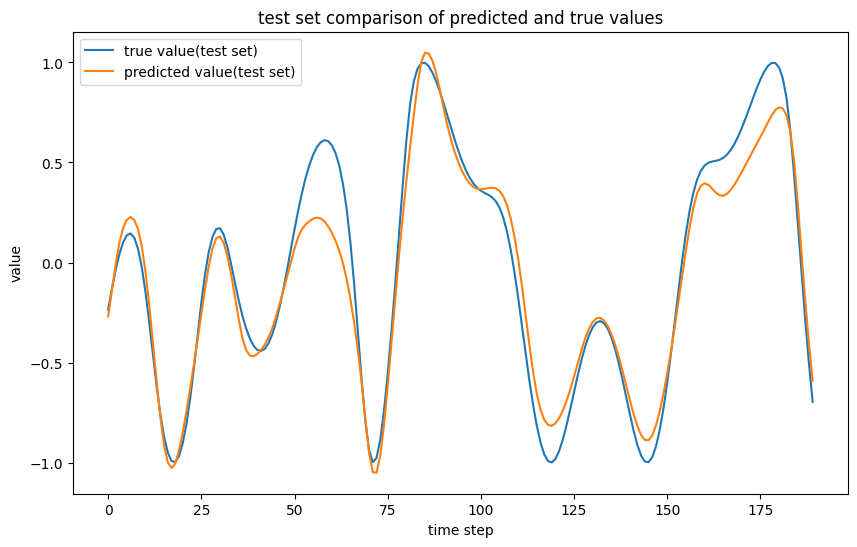

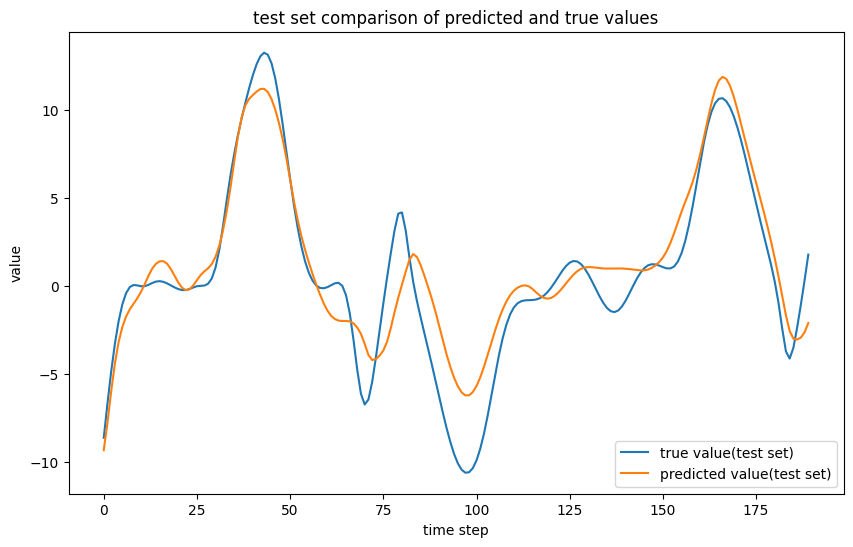

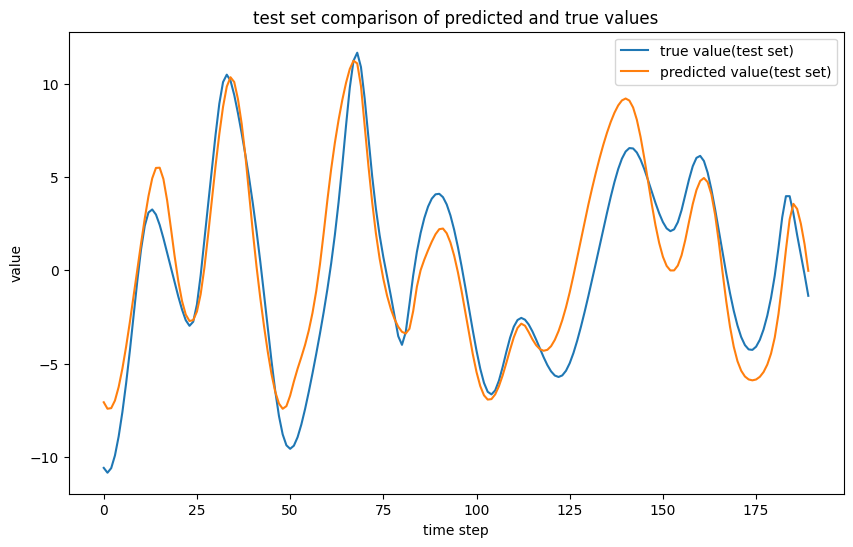

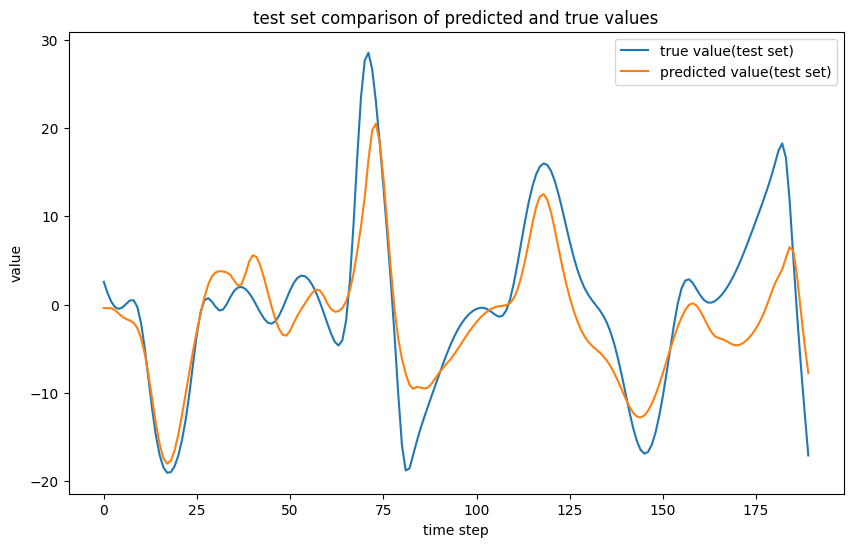

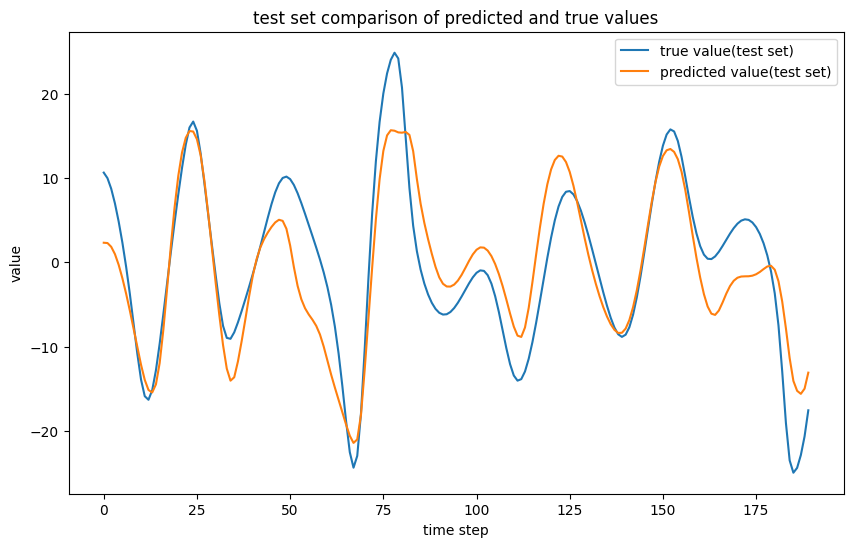

In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
num_layers = 3
output_size = y_train.shape[1]
dropout = 0.2

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(40):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 提取坐标和速度信息并反归一化
        def inverse_transform_single_column(data, scaler, column_index):
            temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
            temp[:, column_index] = data.flatten()
            inverse = scaler.inverse_transform(temp)[:, column_index]
            return inverse.reshape(data.shape)

        x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
        y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
        x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
        y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
        vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
        vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
        vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
        vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

        # 计算角度和角速度
        theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
        theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
        omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
        omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        data_loss = criterion(outputs, yb)
        loss = data_loss + 10**(-8) * phys_loss  # 平衡两项损失

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            data_loss = criterion(outputs, yb)
            loss = data_loss + 10**(-8) * phys_loss
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='predicted value(train set)')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1, 9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

(╯▔皿▔)╯
可能影响最大的还是 data_loss 和 physics_loss 的权重比，扫一遍并作图比较

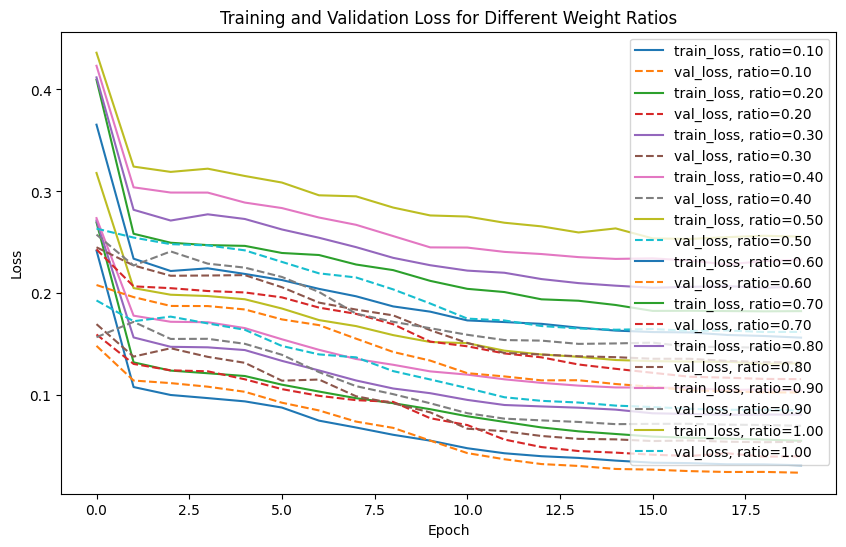

In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
num_layers = 3
output_size = y_train.shape[1]
dropout = 0.2

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 定义不同的权重比
weight_ratios = np.linspace(0.1, 1.0, 10)

# 存储不同权重比下的损失
all_train_losses = []
all_val_losses = []

for weight_ratio in weight_ratios:
    model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    for epoch in range(20):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            data_loss = criterion(outputs, yb)
            loss = data_loss + 10**(-8) * weight_ratio * phys_loss  # 使用当前权重比

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 验证集损失
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                outputs = model(xb)

                # 提取坐标和速度信息并反归一化
                def inverse_transform_single_column(data, scaler, column_index):
                    temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                    temp[:, column_index] = data.flatten()
                    inverse = scaler.inverse_transform(temp)[:, column_index]
                    return inverse.reshape(data.shape)

                x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
                y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
                x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
                y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
                vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
                vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
                vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
                vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

                # 计算角度和角速度
                theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
                theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
                omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
                omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

                A1, A2, B = moment_of_inertia_coefficients()
                delta = angle_difference(theta1, theta2)
                f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
                denom = determinant(A1, A2, B, delta)
                alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

                # 通过差分法计算角加速度
                omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
                omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
                alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
                alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

                # 计算物理约束损失
                phys_loss1 = criterion(alpha1_phys, alpha1_diff)
                phys_loss2 = criterion(alpha2_phys, alpha2_diff)
                phys_loss = phys_loss1 + phys_loss2

                data_loss = criterion(outputs, yb)
                loss = data_loss + 10**(-8) * weight_ratio * phys_loss
                val_loss += loss.item()
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# 绘制不同权重比下的损失曲线
plt.figure(figsize=(10, 6))
for i, weight_ratio in enumerate(weight_ratios):
    plt.plot(all_train_losses[i], label=f'train_loss, ratio={weight_ratio:.2f}')
    plt.plot(all_val_losses[i], label=f'val_loss, ratio={weight_ratio:.2f}', linestyle='--')

plt.title('Training and Validation Loss for Different Weight Ratios')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

看来 weight_ratio=0.6 的效果比较好

Epoch 1, 训练损失: 0.3426, 验证损失: 0.2221
Epoch 2, 训练损失: 0.2317, 验证损失: 0.1848
Epoch 3, 训练损失: 0.2218, 验证损失: 0.1891
Epoch 4, 训练损失: 0.2167, 验证损失: 0.1793
Epoch 5, 训练损失: 0.2088, 验证损失: 0.1708
Epoch 6, 训练损失: 0.2019, 验证损失: 0.1663
Epoch 7, 训练损失: 0.1899, 验证损失: 0.1443
Epoch 8, 训练损失: 0.1846, 验证损失: 0.1396
Epoch 9, 训练损失: 0.1790, 验证损失: 0.1314
Epoch 10, 训练损失: 0.1739, 验证损失: 0.1225
Epoch 11, 训练损失: 0.1680, 验证损失: 0.1170
Epoch 12, 训练损失: 0.1643, 验证损失: 0.1132
Epoch 13, 训练损失: 0.1624, 验证损失: 0.1119
Epoch 14, 训练损失: 0.1595, 验证损失: 0.1046
Epoch 15, 训练损失: 0.1596, 验证损失: 0.1028
Epoch 16, 训练损失: 0.1548, 验证损失: 0.1022
Epoch 17, 训练损失: 0.1592, 验证损失: 0.1006
Epoch 18, 训练损失: 0.1536, 验证损失: 0.1018
Epoch 19, 训练损失: 0.1547, 验证损失: 0.1021
Epoch 20, 训练损失: 0.1535, 验证损失: 0.1000


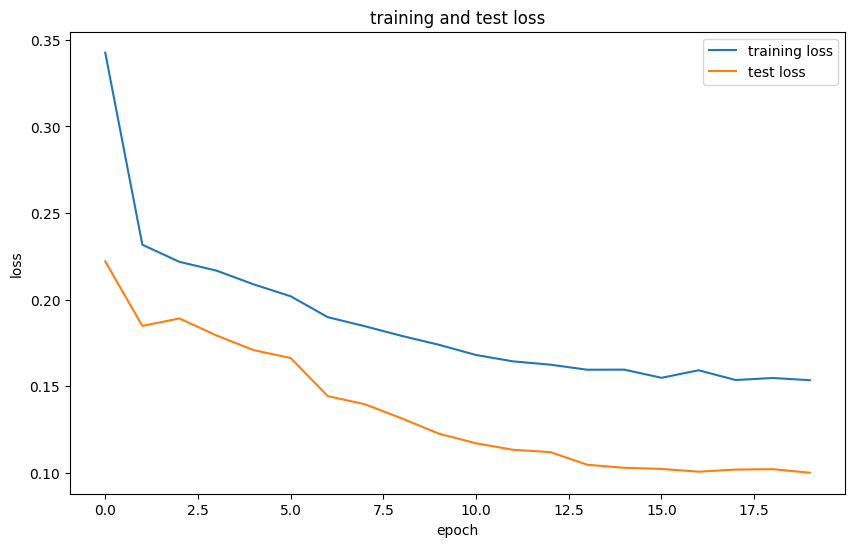

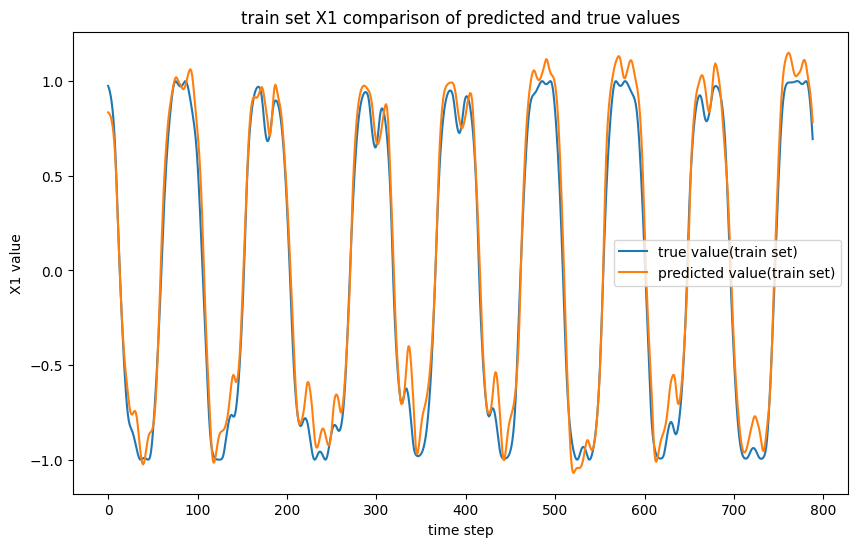

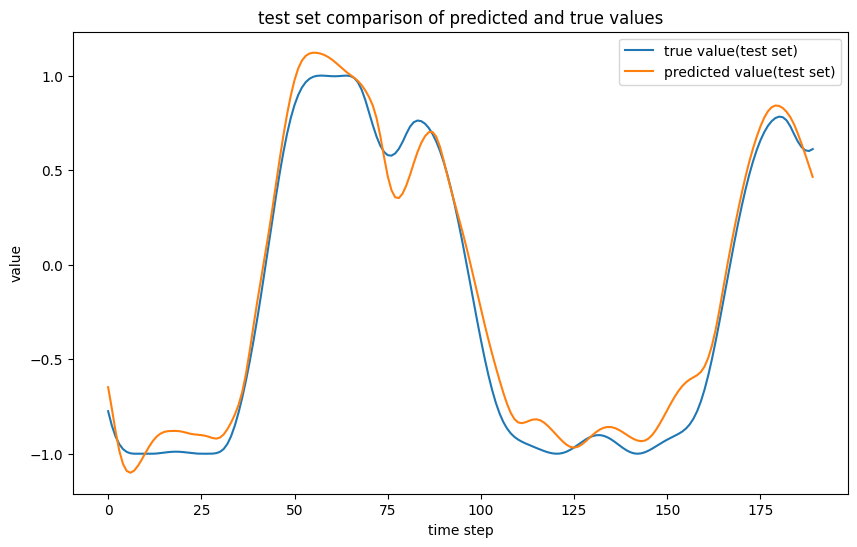

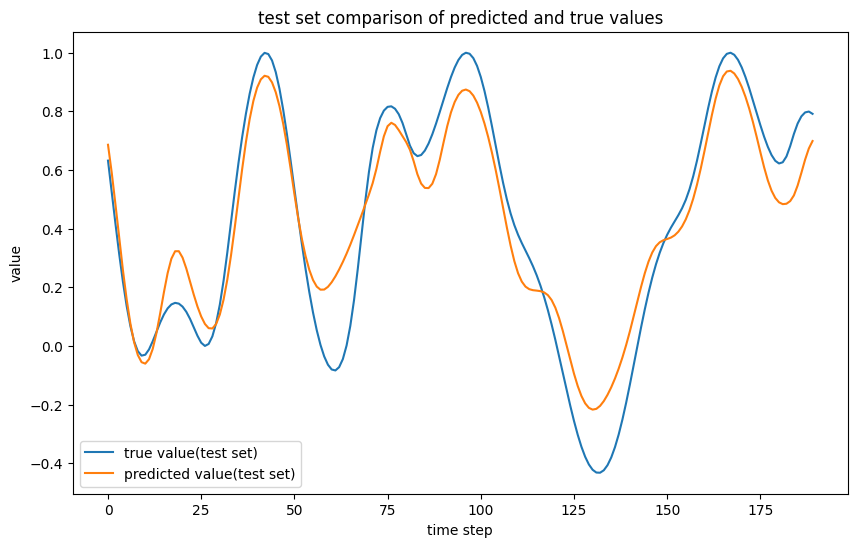

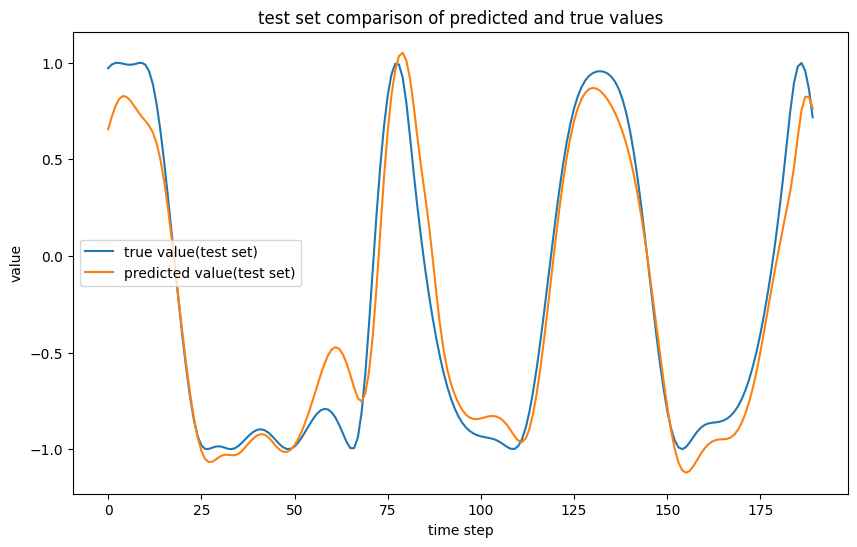

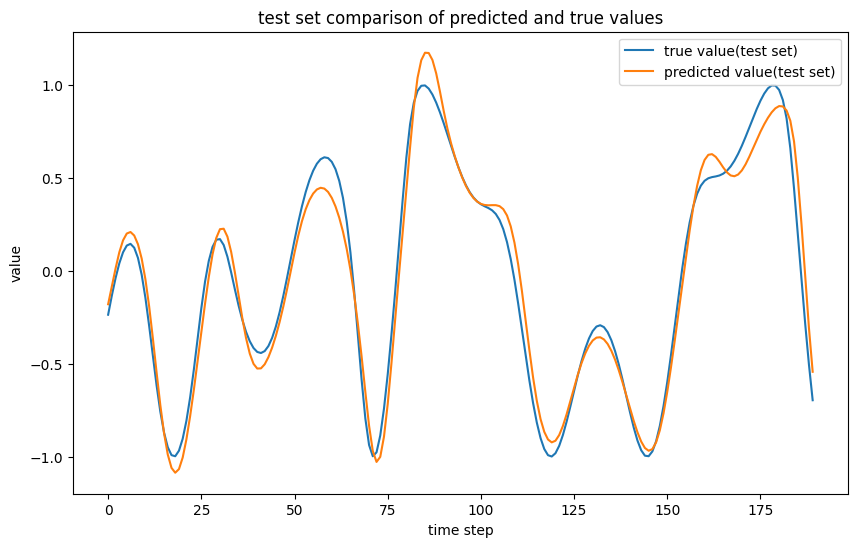

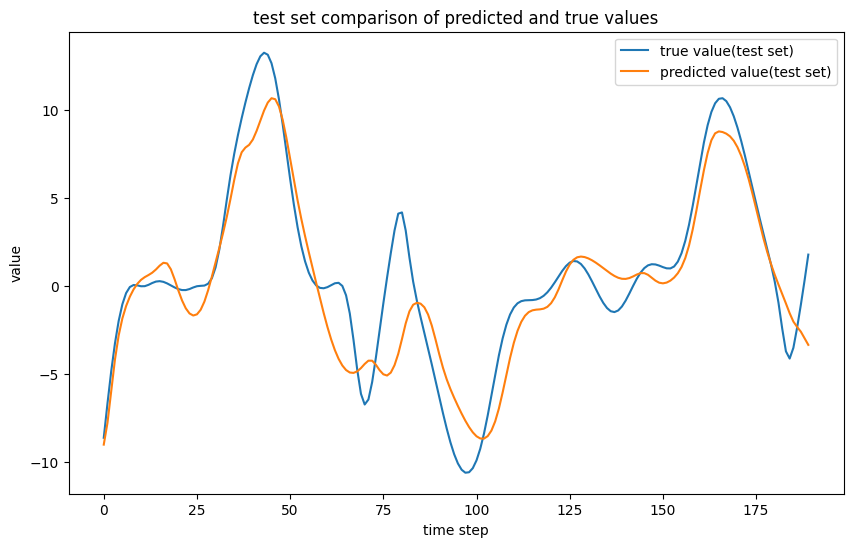

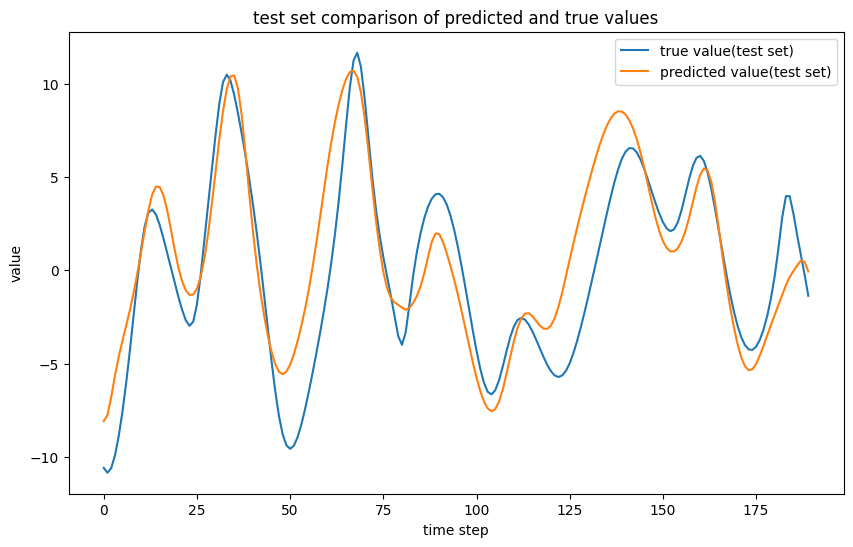

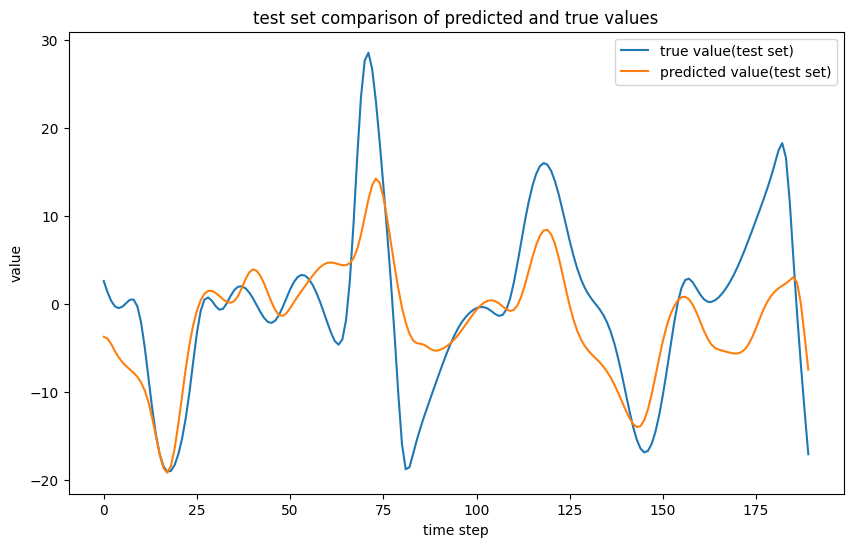

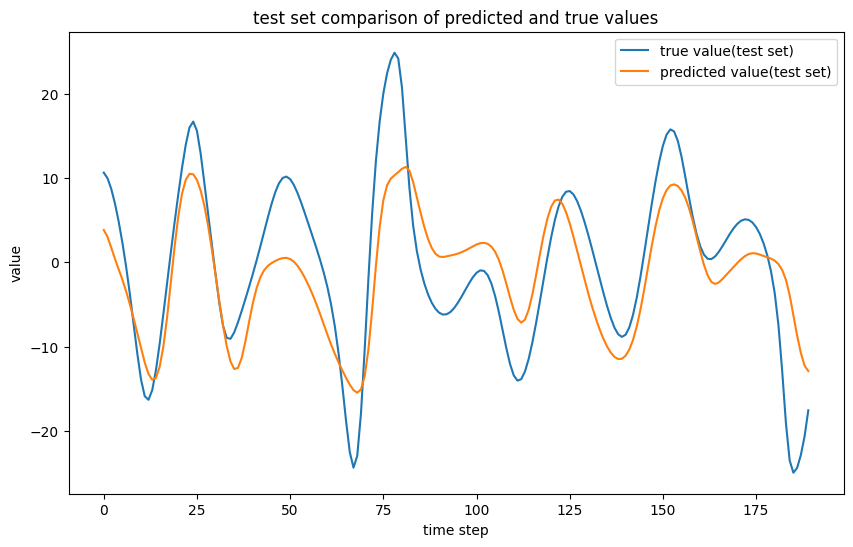

In [11]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('genorator01')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
num_layers = 3
output_size = y_train.shape[1]
dropout = 0.2

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 提取坐标和速度信息并反归一化
        def inverse_transform_single_column(data, scaler, column_index):
            temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
            temp[:, column_index] = data.flatten()
            inverse = scaler.inverse_transform(temp)[:, column_index]
            return inverse.reshape(data.shape)

        x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
        y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
        x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
        y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
        vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
        vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
        vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
        vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

        # 计算角度和角速度
        theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
        theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
        omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
        omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        data_loss = criterion(outputs, yb)
        loss = data_loss + 10**(-8) * 0.6 * phys_loss  # 平衡两项损失

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 提取坐标和速度信息并反归一化
            def inverse_transform_single_column(data, scaler, column_index):
                temp = np.zeros((data.shape[0] * data.shape[1], scaler.n_features_in_))
                temp[:, column_index] = data.flatten()
                inverse = scaler.inverse_transform(temp)[:, column_index]
                return inverse.reshape(data.shape)

            x1 = inverse_transform_single_column(xb[:, :, 1].cpu().numpy(), scaler, 1)
            y1 = inverse_transform_single_column(xb[:, :, 2].cpu().numpy(), scaler, 2)
            x2 = inverse_transform_single_column(xb[:, :, 3].cpu().numpy(), scaler, 3)
            y2 = inverse_transform_single_column(xb[:, :, 4].cpu().numpy(), scaler, 4)
            vx1 = inverse_transform_single_column(xb[:, :, 5].cpu().numpy(), scaler, 5)
            vy1 = inverse_transform_single_column(xb[:, :, 6].cpu().numpy(), scaler, 6)
            vx2 = inverse_transform_single_column(xb[:, :, 7].cpu().numpy(), scaler, 7)
            vy2 = inverse_transform_single_column(xb[:, :, 8].cpu().numpy(), scaler, 8)

            # 计算角度和角速度
            theta1 = torch.atan2(torch.tensor(y1), torch.tensor(x1)).to(device) + 0.5 * np.pi
            theta2 = torch.atan2(torch.tensor(y2 - y1), torch.tensor(x2 - x1)).to(device) + 0.5 * np.pi
            omega1 = torch.sqrt(torch.tensor(vx1 ** 2 + vy1 ** 2)) / l1
            omega2 = torch.sqrt(torch.tensor((vx2 - vx1) ** 2 + (vy2 - vy1) ** 2)) / l2

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            data_loss = criterion(outputs, yb)
            loss = data_loss + 10**(-8) * 0.6 * phys_loss
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='predicted value(train set)')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('X1 value')
plt.legend()
plt.show()

for i in range(1, 9):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

(╯▔皿▔)╯
看一下泛化能力

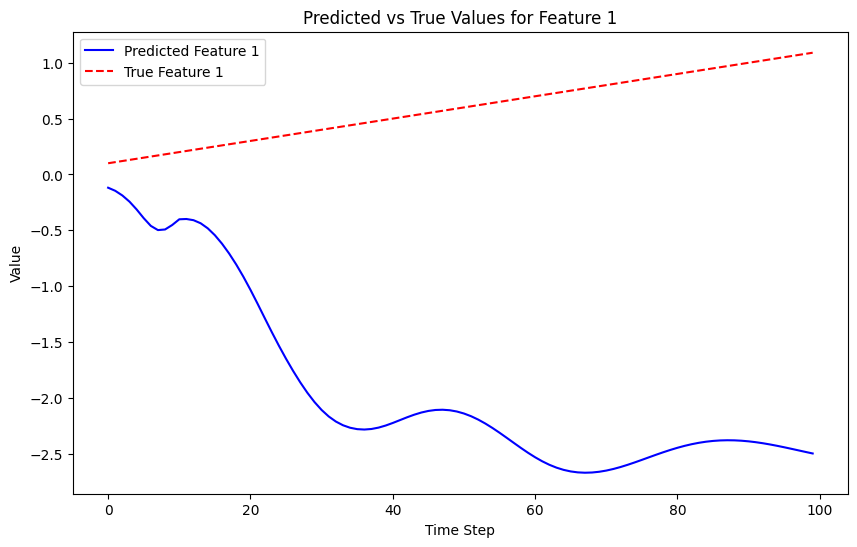

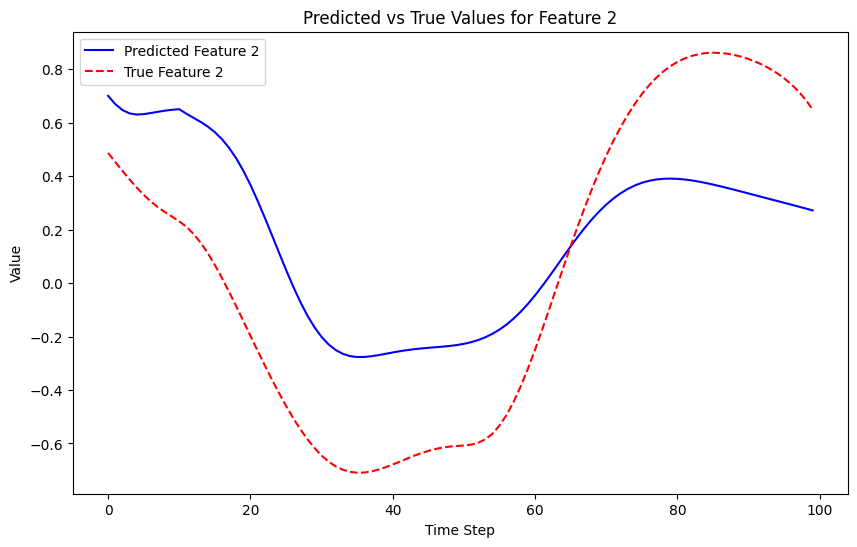

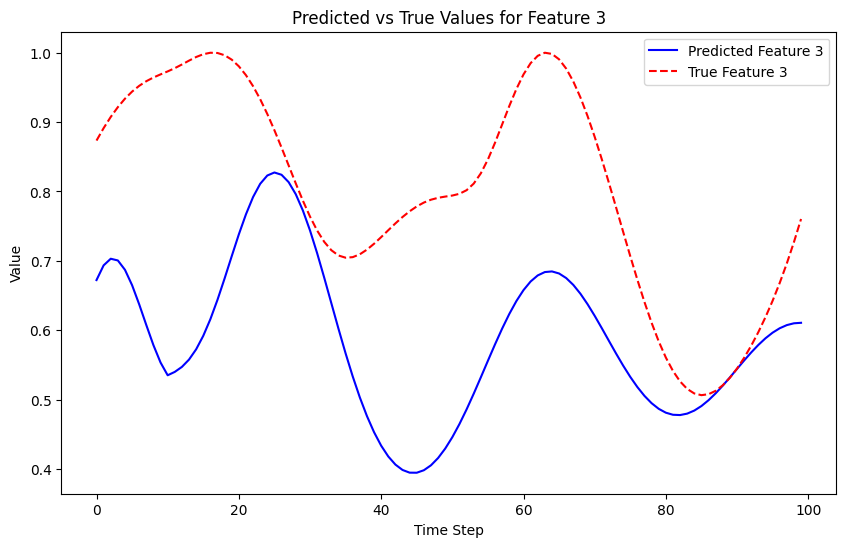

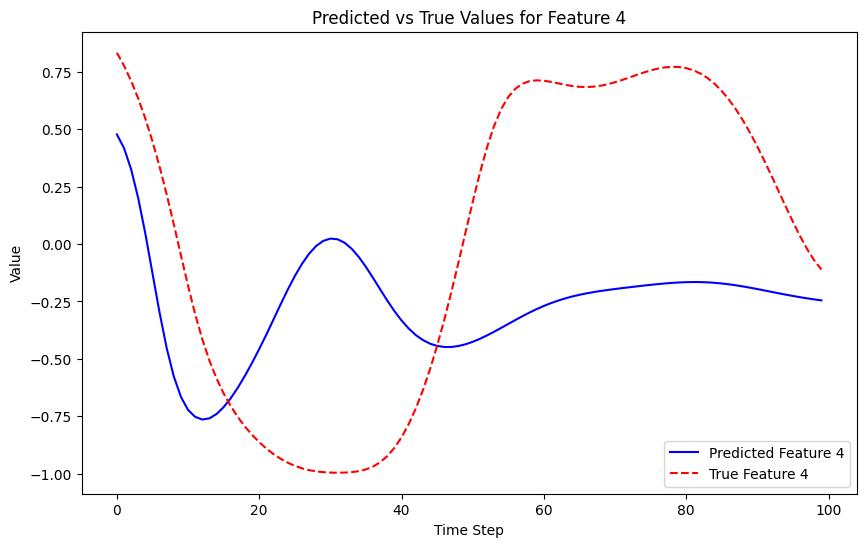

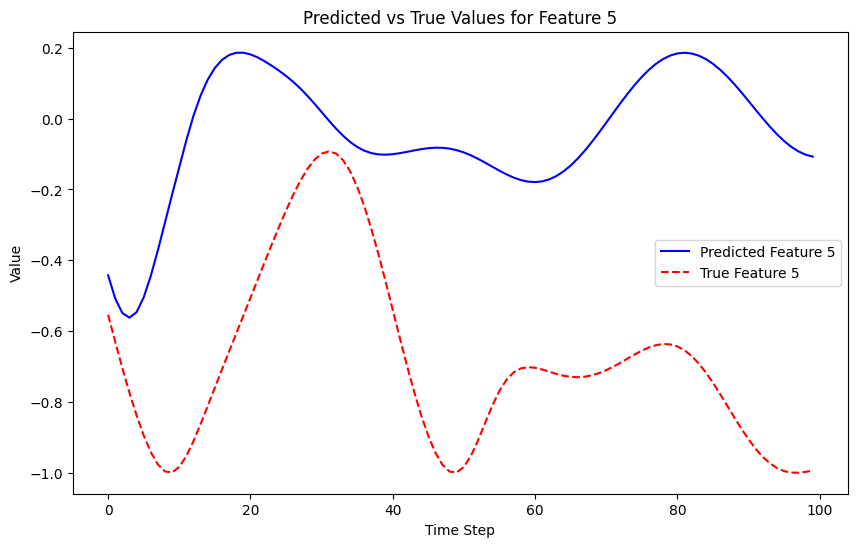

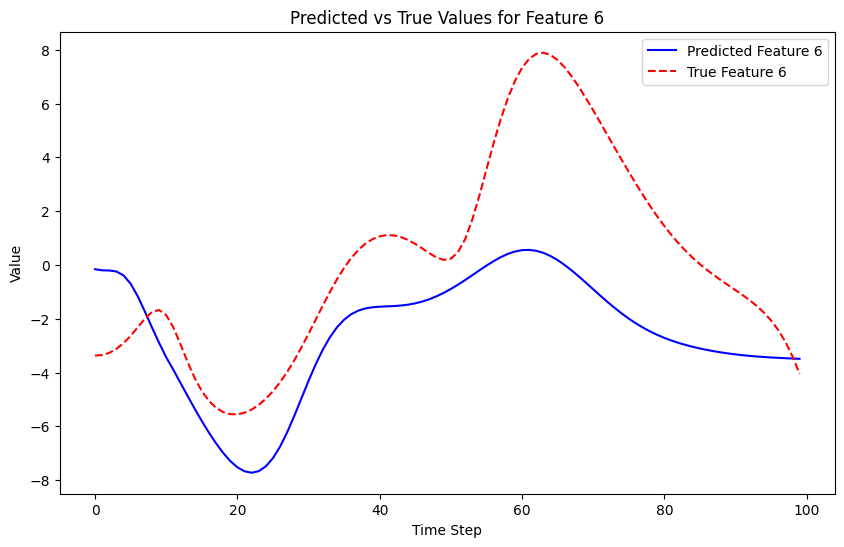

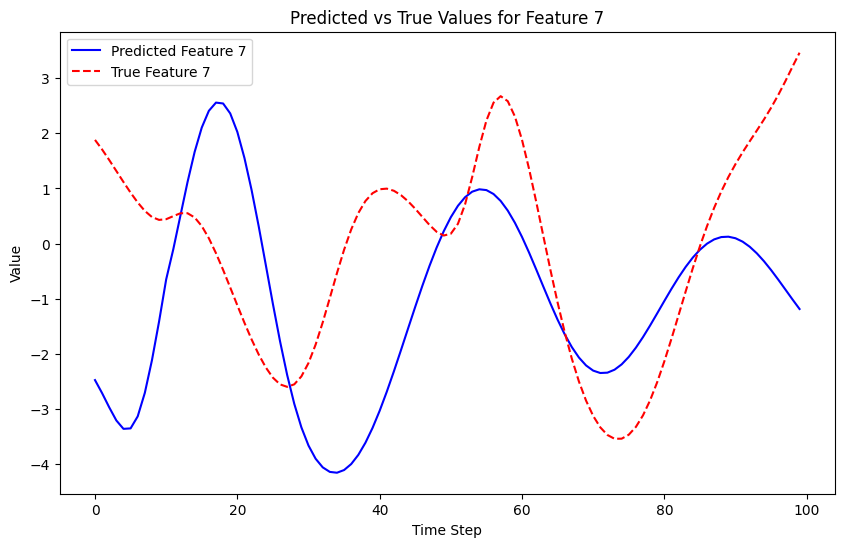

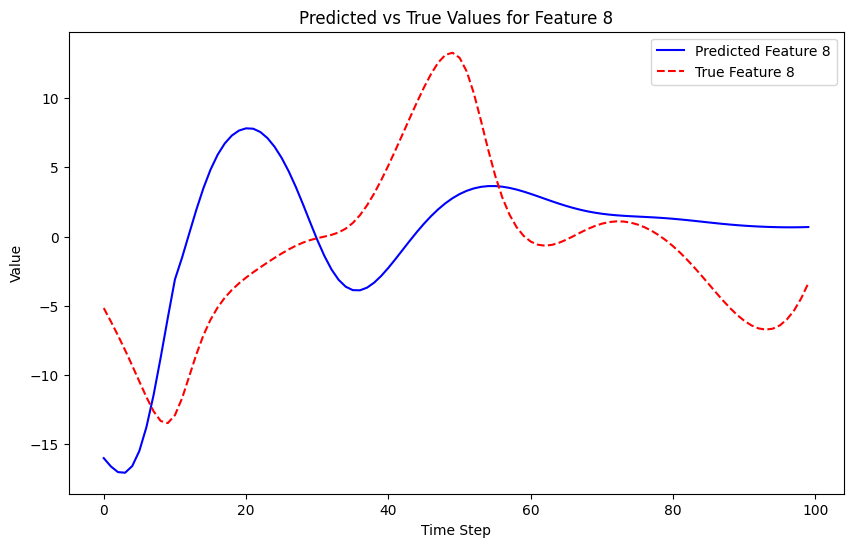

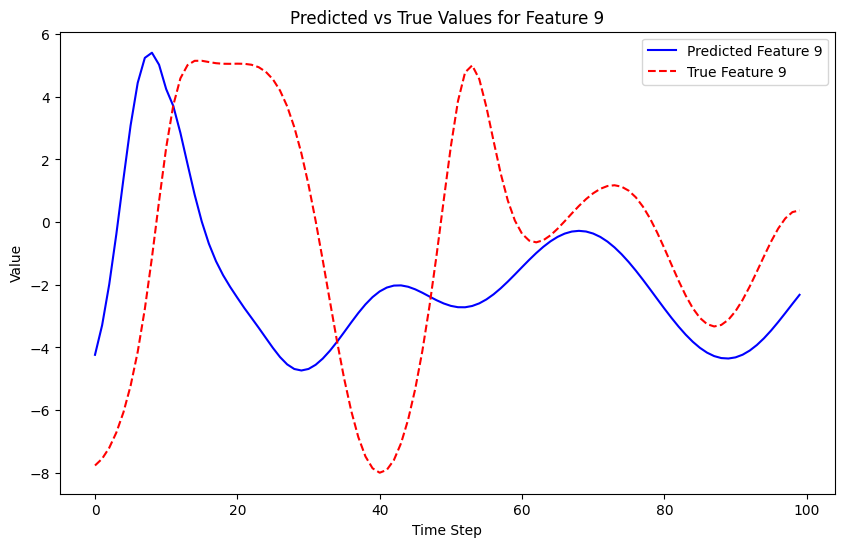

In [14]:
# 保存模型权重
torch.save(model.state_dict(), 'lstm_model_weights.pth')

# 读取新的数据集
new_excel_file = pd.ExcelFile('test03.xlsx')
new_df = new_excel_file.parse('Sheet1')  # 假设工作表名相同
new_df = new_df.iloc[::10]
new_scaled_data = scaler.transform(new_df.values)  # 使用之前的scaler进行归一化

# 取前十个数据点作为初始输入
initial_data = new_scaled_data[:10]
initial_data = np.array([initial_data])  # 增加一个维度，变为 [batch_size, seq_length, feature_size]
initial_data_tensor = torch.tensor(initial_data, dtype=torch.float32).to(device)

# 迭代预测后100个数据点
predicted_data = []
with torch.no_grad():
    model.eval()
    for _ in range(100):
        output = model(initial_data_tensor)
        predicted_data.append(output.cpu().numpy()[0])
        # 更新输入数据，将预测值作为新的输入
        initial_data = np.roll(initial_data, -1, axis=1)
        initial_data[0, -1, :] = output.cpu().numpy()[0]
        initial_data_tensor = torch.tensor(initial_data, dtype=torch.float32).to(device)

# 反归一化
predicted_data = scaler.inverse_transform(np.array(predicted_data))

# 获取新数据集中后100个数据点的真实值
true_data = new_df.iloc[10:110].values

# 分开绘制九张图
for i in range(min(9, output_size)):
    plt.figure(figsize=(10, 6))
    plt.plot(predicted_data[:, i], label=f'Predicted Feature {i + 1}', color='blue')
    plt.plot(true_data[:, i], label=f'True Feature {i + 1}', color='red', linestyle='--')
    plt.title(f'Predicted vs True Values for Feature {i + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

泛化效果很差
看看直接用角度和角速度会不会更好一些呢/(ㄒoㄒ)/~~

Epoch 1, 训练损失: 0.0360, 验证损失: 0.0228
Epoch 2, 训练损失: 0.0025, 验证损失: 0.0024
Epoch 3, 训练损失: 0.0012, 验证损失: 0.0015
Epoch 4, 训练损失: 0.0008, 验证损失: 0.0012
Epoch 5, 训练损失: 0.0007, 验证损失: 0.0011
Epoch 6, 训练损失: 0.0006, 验证损失: 0.0010
Epoch 7, 训练损失: 0.0006, 验证损失: 0.0009
Epoch 8, 训练损失: 0.0006, 验证损失: 0.0010
Epoch 9, 训练损失: 0.0006, 验证损失: 0.0009
Epoch 10, 训练损失: 0.0005, 验证损失: 0.0008


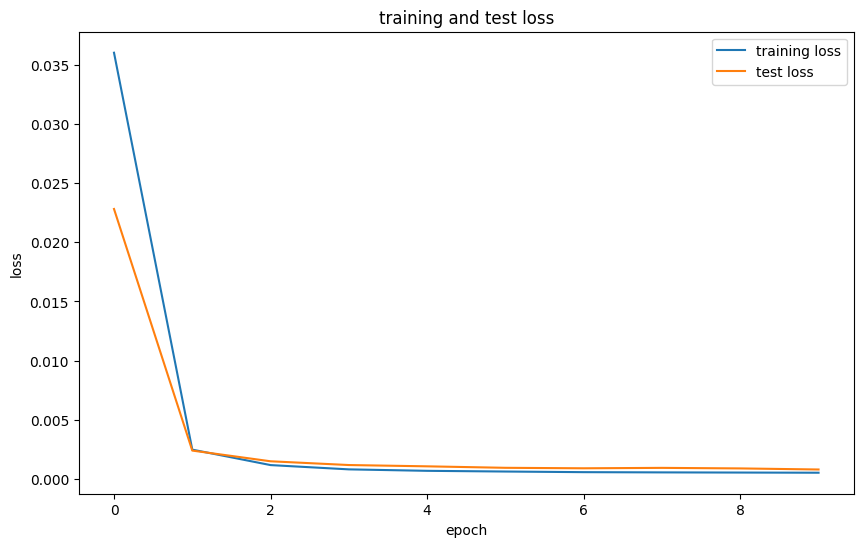

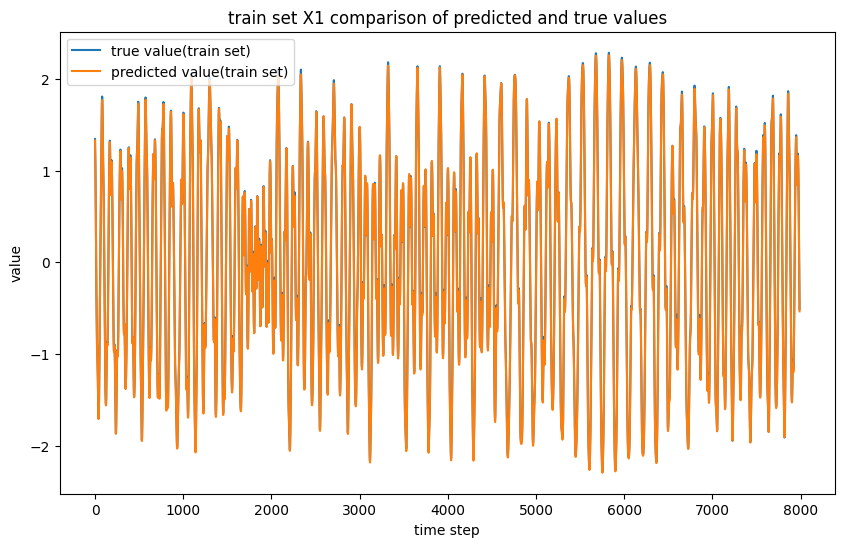

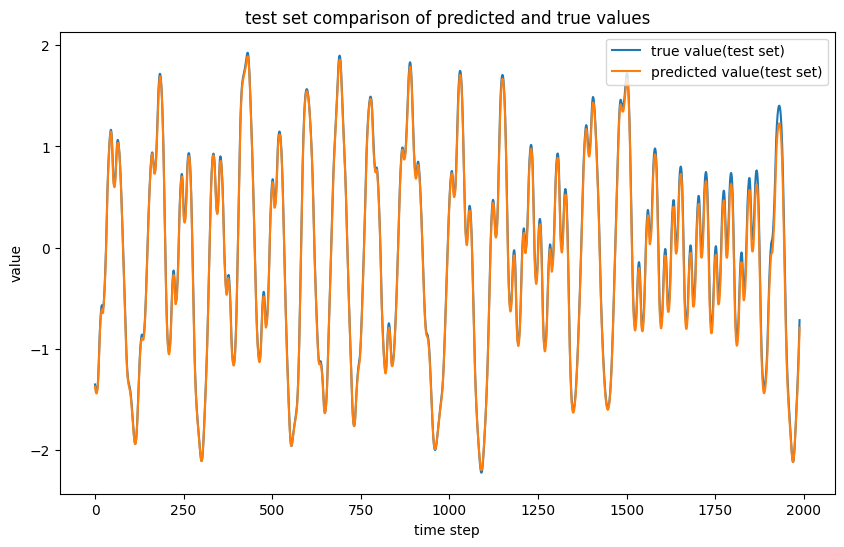

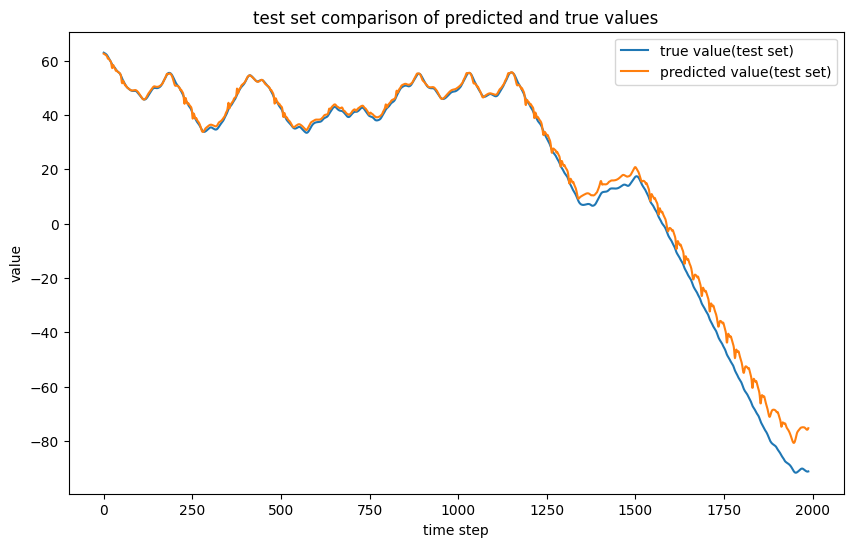

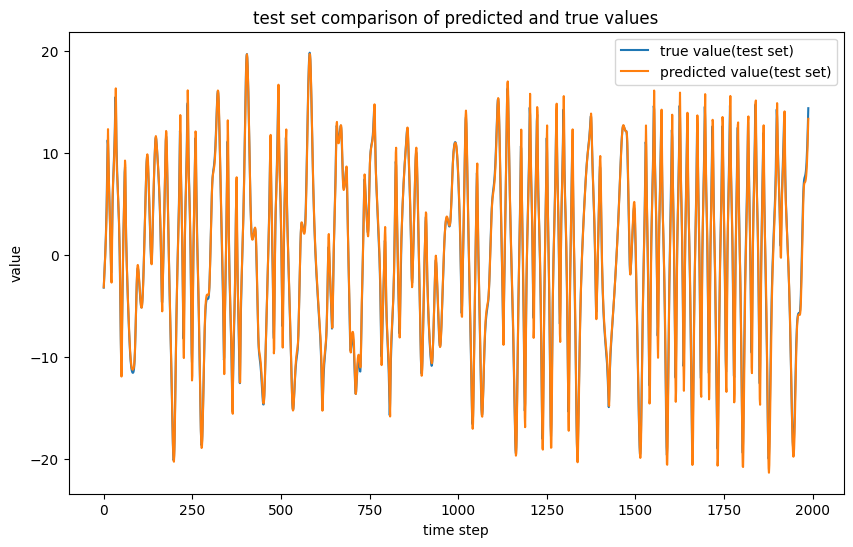

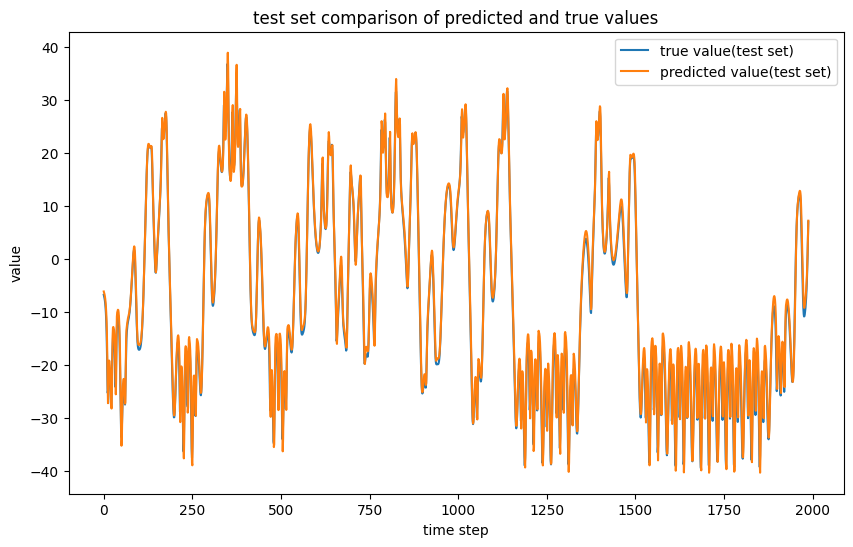

In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 读取 Excel 文件
excel_file = pd.ExcelFile('test01_theta.xlsx')
sheet_names = excel_file.sheet_names
df = excel_file.parse('Sheet1')

# 每十个点取一个数据
df = df.iloc[::10]

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# 划分训练集和测试集
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:, :]

# 创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义GRU模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
output_size = y_train.shape[1]

model = GRUModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 训练模型
train_losses, val_losses = [], []
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 用角度和角速度
        theta1 = xb[:, :, 1]  
        theta2 = xb[:, :, 2]  
        omega1 = xb[:, :, 3]  
        omega2 = xb[:, :, 4]  

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        loss = criterion(outputs, yb) + 10**(-8) * phys_loss  # 调整权重平衡两项损失
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 角度和角速度
            theta1 = xb[:, :, 1]  
            theta2 = xb[:, :, 2]  
            omega1 = xb[:, :, 3]  
            omega2 = xb[:, :, 4]  

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            loss = criterion(outputs, yb) + 10**(-8) * phys_loss  # 调整权重平衡两项损失
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 模型预测
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='test loss')
plt.title('training and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 绘制预测结果对比（X1）
plt.figure(figsize=(10, 6))
plt.plot(y_train[:, 1], label='true value(train set)')
plt.plot(train_predict[:, 1], label='predicted value(train set)')
plt.title('train set X1 comparison of predicted and true values')
plt.xlabel('time step')
plt.ylabel('value')
plt.legend()
plt.show()

for i in range(1, 5):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[:, i], label='true value(test set)')
    plt.plot(test_predict[:, i], label='predicted value(test set)')
    plt.title('test set comparison of predicted and true values')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()

用角度明显好多了
再看看泛化能力

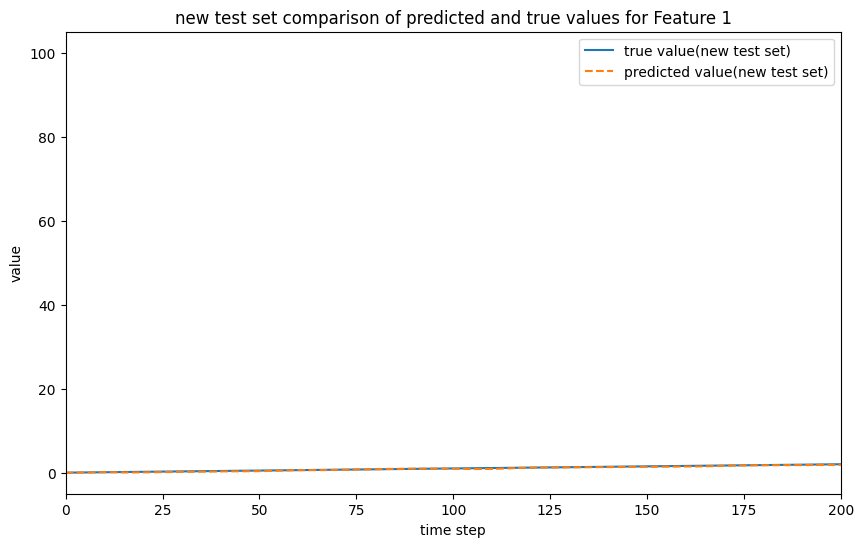

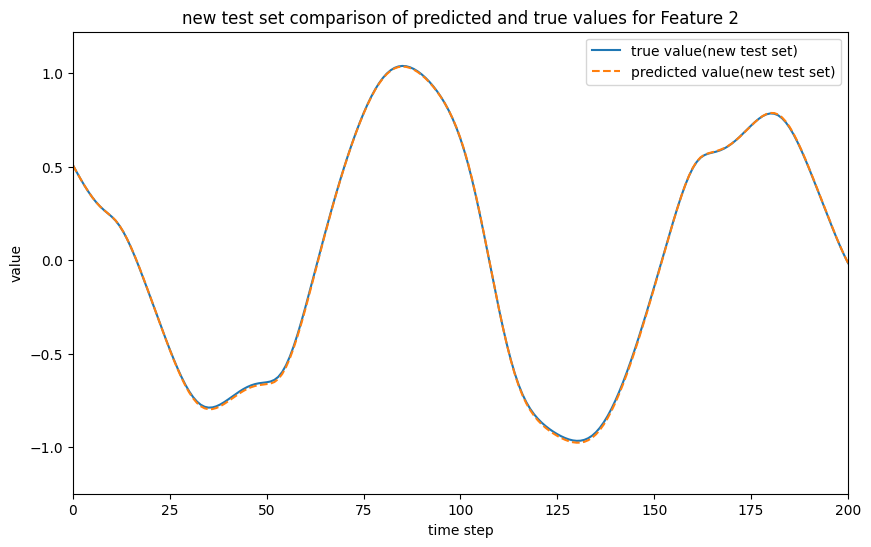

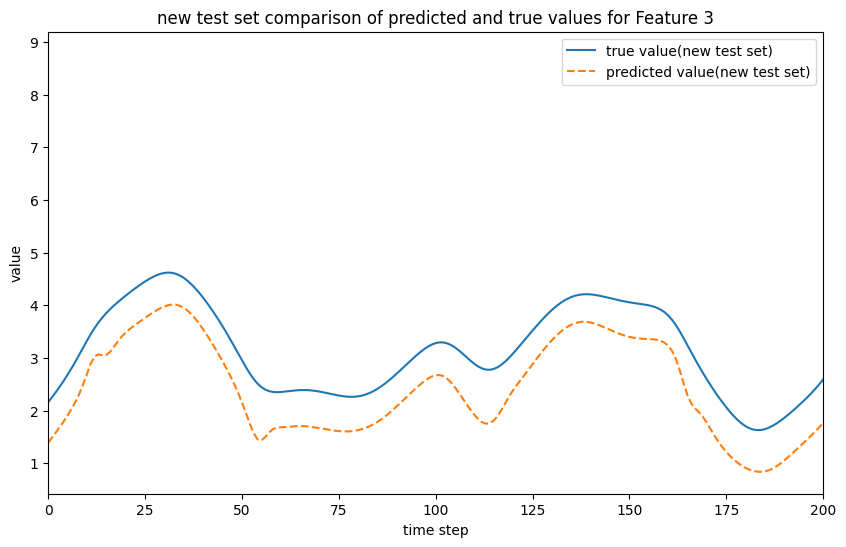

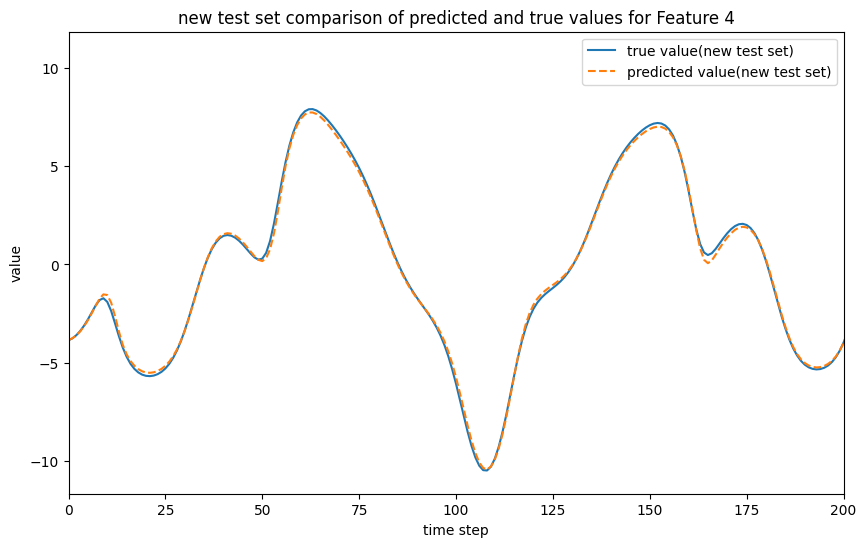

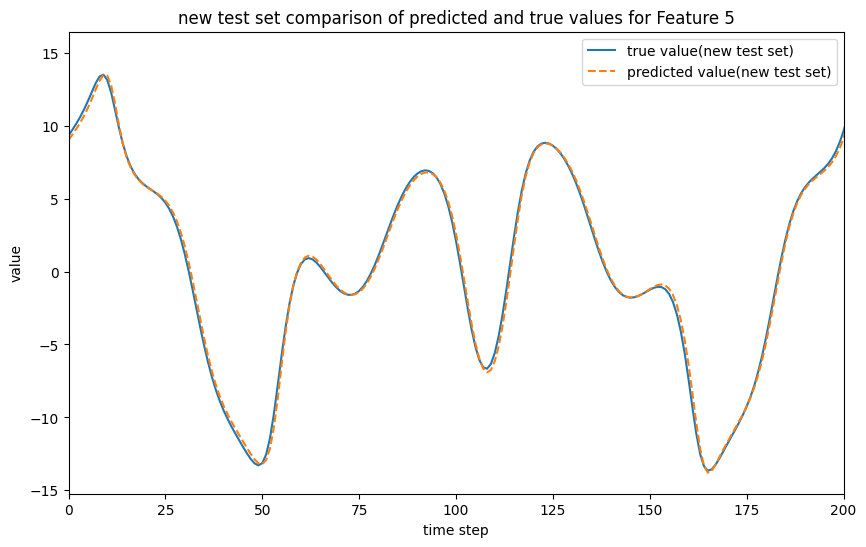

In [26]:
# 保存模型
torch.save(model.state_dict(), 'gru_model.pth')

# 读取新的数据集用于测试泛化能力
new_excel_file = pd.ExcelFile('test03_theta.xlsx')
new_df = new_excel_file.parse('Sheet1')  # 请替换为实际的工作表名
new_df = new_df.iloc[::10]

# 数据归一化（使用之前训练集的scaler）
new_scaled_data = scaler.transform(new_df.values)

# 创建时间序列数据
new_X, new_y = create_dataset(new_scaled_data, time_step)
new_X_tensor = torch.tensor(new_X, dtype=torch.float32).to(device)
new_y_tensor = torch.tensor(new_y, dtype=torch.float32).to(device)

# 加载模型
model.load_state_dict(torch.load('gru_model.pth'))
model.eval()

# 模型预测
with torch.no_grad():
    new_predict = model(new_X_tensor).cpu().numpy()

# 反归一化
new_predict = scaler.inverse_transform(new_predict)
new_y = scaler.inverse_transform(new_y)

# 绘制预测结果对比图
for i in range(min(9, new_y.shape[1])):
    plt.figure(figsize=(10, 6))
    plt.plot(new_y[:, i], label='true value(new test set)')
    plt.plot(new_predict[:, i], label='predicted value(new test set)', linestyle='--')
    plt.xlim(0, 200)  # 限制x轴范围为0到100
    plt.title(f'new test set comparison of predicted and true values for Feature {i + 1}')
    plt.xlabel('time step')
    plt.ylabel('value')
    plt.legend()
    plt.show()


泛化能力还可以

Epoch 1, 训练损失: 0.0354, 验证损失: 0.0061
Epoch 2, 训练损失: 0.0036, 验证损失: 0.0023
Epoch 3, 训练损失: 0.0017, 验证损失: 0.0016
Epoch 4, 训练损失: 0.0012, 验证损失: 0.0012
Epoch 5, 训练损失: 0.0009, 验证损失: 0.0008
Epoch 6, 训练损失: 0.0007, 验证损失: 0.0007
Epoch 7, 训练损失: 0.0007, 验证损失: 0.0008
Epoch 8, 训练损失: 0.0006, 验证损失: 0.0005
Epoch 9, 训练损失: 0.0006, 验证损失: 0.0004
Epoch 10, 训练损失: 0.0005, 验证损失: 0.0005


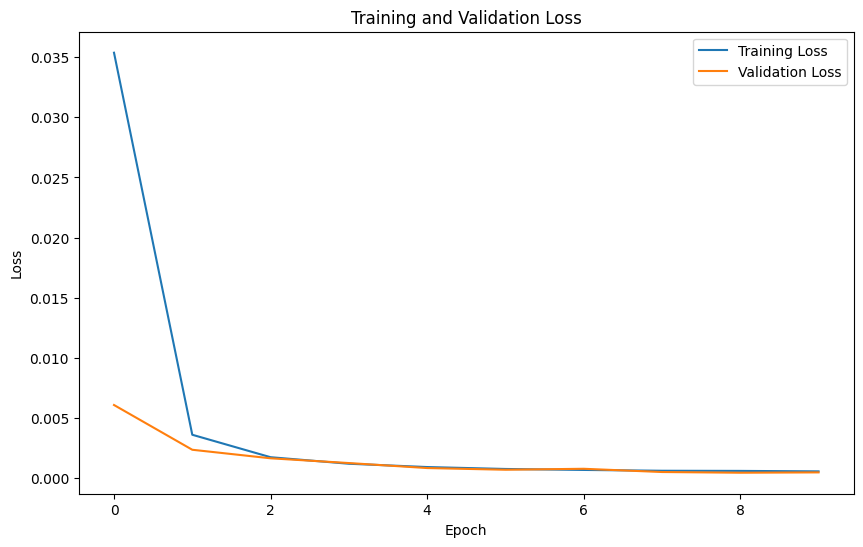

在第三个数据集上的测试损失: 1507.7371


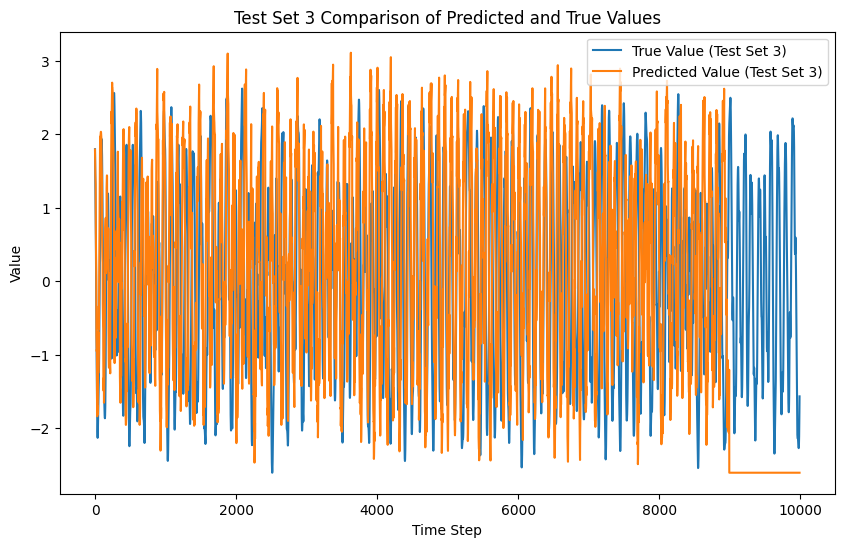

In [30]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import product

# 定义函数读取和预处理数据集
def load_and_preprocess_data(file_path):
    # 读取 Excel 文件
    excel_file = pd.ExcelFile(file_path)
    df = excel_file.parse('Sheet1')

    # 每十个点取一个数据
    df = df.iloc[::10]

    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    return scaled_data, scaler

# 定义函数创建时间序列数据
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 物理参数
m1 = m2 = 0.02
l1 = l2 = 0.2
g = 9.81
dt = 0.001 * 10

# 计算角度差
def angle_difference(theta1, theta2):
    return theta1 - theta2

# 计算转动惯量相关系数
def moment_of_inertia_coefficients():
    A1 = (1 / 3) * m1 * l1 ** 2 + m2 * l1 ** 2
    A2 = (1 / 3) * m2 * l2 ** 2
    B = (1 / 2) * m2 * l1 * l2
    return A1, A2, B

# 计算右端项函数
def right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B):
    delta = angle_difference(theta1, theta2)
    f1 = -g * ((1 / 2) * m1 * l1 + m2 * l1) * torch.sin(theta1) - B * torch.sin(delta) * omega2 ** 2
    f2 = B * torch.sin(delta) * omega1 ** 2 + (1 / 2) * g * m2 * l2 * torch.sin(theta2)
    return f1, f2

# 计算系数矩阵的行列式
def determinant(A1, A2, B, delta):
    return A1 * A2 - (B * torch.cos(delta)) ** 2

# 计算角加速度
def angular_accelerations(f1, f2, A1, A2, B, delta, denom):
    alpha1 = (A2 * f1 - B * torch.cos(delta) * f2) / denom
    alpha2 = (-B * torch.cos(delta) * f1 + A1 * f2) / denom
    return alpha1, alpha2

# 数据集文件路径
file_paths = ['test01_theta.xlsx', 'test03_theta.xlsx', 'test04_theta.xlsx']

# 加载前两个数据集
scaled_data_1, scaler_1 = load_and_preprocess_data(file_paths[0])
scaled_data_2, scaler_2 = load_and_preprocess_data(file_paths[1])

# 合并前两个数据集
combined_scaled_data = np.concatenate((scaled_data_1, scaled_data_2), axis=0)

# 划分训练集和测试集
train_size = int(len(combined_scaled_data) * 0.8)
train_data = combined_scaled_data[0:train_size, :]
test_data = combined_scaled_data[train_size:, :]

# 创建时间序列数据
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转为 Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义参数
input_size = X_train.shape[2]
hidden_size = 100
num_layers = 3
output_size = y_train.shape[1]
learning_rate = 0.001
phys_loss_weight = 1e-8

# 初始化模型
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
train_losses, val_losses = [], []
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)

        # 用角度和角速度
        theta1 = xb[:, :, 1]
        theta2 = xb[:, :, 2]
        omega1 = xb[:, :, 3]
        omega2 = xb[:, :, 4]

        A1, A2, B = moment_of_inertia_coefficients()
        delta = angle_difference(theta1, theta2)
        f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
        denom = determinant(A1, A2, B, delta)
        alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

        # 通过差分法计算角加速度
        omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
        omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
        alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
        alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

        # 计算物理约束损失
        phys_loss1 = criterion(alpha1_phys, alpha1_diff)
        phys_loss2 = criterion(alpha2_phys, alpha2_diff)
        phys_loss = phys_loss1 + phys_loss2

        loss = criterion(outputs, yb) + phys_loss_weight * phys_loss  # 调整权重平衡两项损失
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 验证集损失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            outputs = model(xb)

            # 角度和角速度
            theta1 = xb[:, :, 1]
            theta2 = xb[:, :, 2]
            omega1 = xb[:, :, 3]
            omega2 = xb[:, :, 4]

            A1, A2, B = moment_of_inertia_coefficients()
            delta = angle_difference(theta1, theta2)
            f1, f2 = right_hand_side_functions(theta1, theta2, omega1, omega2, A1, A2, B)
            denom = determinant(A1, A2, B, delta)
            alpha1_phys, alpha2_phys = angular_accelerations(f1, f2, A1, A2, B, delta, denom)

            # 通过差分法计算角加速度
            omega1_diff = (omega1[:, 1:] - omega1[:, :-1]) / dt
            omega2_diff = (omega2[:, 1:] - omega2[:, :-1]) / dt
            alpha1_diff = torch.cat([omega1_diff[:, 0].unsqueeze(1), omega1_diff], dim=1)
            alpha2_diff = torch.cat([omega2_diff[:, 0].unsqueeze(1), omega2_diff], dim=1)

            # 计算物理约束损失
            phys_loss1 = criterion(alpha1_phys, alpha1_diff)
            phys_loss2 = criterion(alpha2_phys, alpha2_diff)
            phys_loss = phys_loss1 + phys_loss2

            loss = criterion(outputs, yb) + phys_loss_weight * phys_loss  # 调整权重平衡两项损失
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}, 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}")

# 保存模型权重
torch.save(model.state_dict(), 'lstm_model_weights.pth')

# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 加载第三个数据集
scaled_data_3, scaler_3 = load_and_preprocess_data(file_paths[2])
X_test_3, y_test_3 = create_dataset(scaled_data_3, time_step)
X_test_3_tensor = torch.tensor(X_test_3, dtype=torch.float32).to(device)
y_test_3_tensor = torch.tensor(y_test_3, dtype=torch.float32).to(device)

test_dataset_3 = TensorDataset(X_test_3_tensor, y_test_3_tensor)
test_loader_3 = DataLoader(test_dataset_3, batch_size=64, shuffle=False)

# 加载保存的模型权重
model.load_state_dict(torch.load('lstm_model_weights.pth'))
model.eval()

# 混合预测
predictions = []
# 初始化前十个真实值
current_input = X_test_3[0].reshape(1, time_step, -1)
current_input_tensor = torch.tensor(current_input, dtype=torch.float32).to(device)

for i in range(len(y_test_3)):
    if i % 10 == 0 and i > 0:
        # 每十步用真实值修正
        current_input = X_test_3[i].reshape(1, time_step, -1)
        current_input_tensor = torch.tensor(current_input, dtype=torch.float32).to(device)
    else:
        # 用预测值更新输入
        with torch.no_grad():
            pred = model(current_input_tensor)
        predictions.append(pred.cpu().numpy().flatten())
        new_input = np.roll(current_input, -1, axis=1)
        new_input[0, -1, :] = pred.cpu().numpy()
        current_input = new_input
        current_input_tensor = torch.tensor(current_input, dtype=torch.float32).to(device)

# 确保预测值和真实值长度一致
predictions = np.array(predictions)
if len(predictions) < len(y_test_3):
    # 如果预测值数量少于真实值数量，补充零值（可以根据实际情况调整）
    num_missing = len(y_test_3) - len(predictions)
    padding = np.zeros((num_missing, predictions.shape[1]))
    predictions = np.vstack((predictions, padding))
elif len(predictions) > len(y_test_3):
    # 如果预测值数量多于真实值数量，截断
    predictions = predictions[:len(y_test_3)]

# 反归一化
predictions = scaler_3.inverse_transform(predictions)
y_test_3 = scaler_3.inverse_transform(y_test_3)

# 计算测试损失
test_loss = criterion(torch.tensor(predictions, dtype=torch.float32), torch.tensor(y_test_3, dtype=torch.float32)).item()
print(f"在第三个数据集上的测试损失: {test_loss:.4f}")

# 绘制预测结果对比
plt.figure(figsize=(10, 6))
plt.plot(y_test_3[:, 1], label='True Value (Test Set 3)')
plt.plot(predictions[:, 1], label='Predicted Value (Test Set 3)')
plt.title('Test Set 3 Comparison of Predicted and True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()